# TODO
- [x] Rerun for 100 params for > 300 simulations reach (to fill up rank histogram)
- [x] Implement CRPS for example
- [x] Run RMSE for example

# Best Calibration Day

In the context of ensemble Kalman filters methods such at the ensemble adjustment Kalman filter (EAKF), calibration refers to the degree to which the filter's statistical estimates match the true underlying statistics of the system being observed and modeled. Good calibration in an EAKF means that the probabilistic predictions produced by the filter accurately represent the true uncertainty in the system's state. This entails two key aspects:

1. **Reliability**: The ensemble spread should reflect the true uncertainty of the system. If the filter is well-calibrated, the observed values should, over time, fall within the predicted ranges (e.g., confidence intervals) at a rate consistent with the stated probabilities. For example, in a perfectly calibrated system, if the ensemble filter indicates a 90% credible interval for a particular variable, then the true value of that variable should fall within this range 90% of the time.

2. **Bias**: A well-calibrated EAKF should have minimal bias in its posterior. This means that, on average, the ensemble mean (or median, depending on the distribution) should be close to the true mean of the system's state. There should be no systematic overestimation or underestimation of the true state by the filter.

This notebook attempts to answer the following question.


**Question:** Is there an optimal day in the time-series where the calibration is optimal?

For each day, we investigate the following diagnostic tools and metrics that assess calibration:
1. ~~**Rank-Histogram**~~
    
    Rank histograms, also known as Talagrand diagrams, are used to evaluate the calibration of a filter. To create the rank histogram, for each observational data point:

    - Insert the observation into the ordered sequence of the ensemble values.
    - Record the rank of the observation within this sequence.
    
    \
    If the filter is perfectly calibrated, the rank histogram should be flat, indicating that the observations are equally likely to fall in any place within the sorted ensemble. A U-shaped histogram suggests underdispersion (the filter is too confident), while a hill-shaped (inverted U) histogram indicates overdispersion (the ensemble is not confident enough). Skewness in the histogram suggests a bias in the filter.

2. ~~**Reliability Plot**~~

    Reliability plots compare the filter probabilities against the observed frequencies for different probabilistic bins. In a reliability plot, the perfect reliability line is a 45-degree diagonal line. Points above the line indicate underforecasting (events were more likely than predicted), and points below the line indicate overforecasting (events were less likely than predicted). The closer the plotted points are to the diagonal, the more reliable the filter.
    
3. **Continuous Ranked Probability Score (CRPS)**

    The Continuous Ranked Probability Score (CRPS) is a commonly used proper scoring rule for evaluating the accuracy of probabilistic predictions. It measures the difference between the prediction cumulative distribution function (CDF) and the observed CDF, summed across all possible values. The CRPS is especially useful for ensemble predictions because it can directly use the ensemble members to construct the prediction CDF. A lower CRPS indicates a better filter, with a CRPS of 0 indicating a perfect prediction. It is defined as
    $$
    C R P S(F, y)=\int_{\mathbb{R}}(F(x)-\mathbb{1}_{x \geq y})^2 d x
    $$
    where $F$ is the prediction cumulative distribution function $y \in \mathbb{R}$ is the observation.
    \
    Reference: https://sites.stat.washington.edu/raftery/Research/PDF/Gneiting2007jasa.pdf
    
    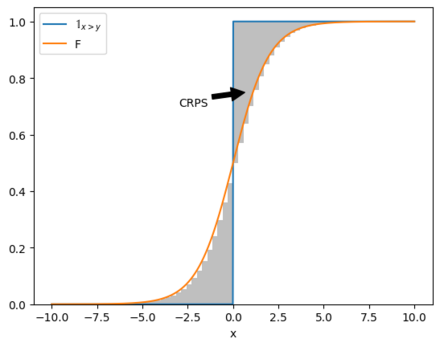
    
4. **RMSE**
    

Rerun for only 100 parameter scenarios since it takes FOREVER to do the full set. We will rerun for full set of parameters if there's anything interesting here...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import pickle
from tqdm import tqdm

from epyfilter import posterior_checks


## Run for one example parameter scenario

In [2]:
# choose one param as an example
param_list = pd.read_csv("/ifs/scratch/jls106_gp/nhw2114/repos/rt-estimation/src/epyfilter/c2b2/good_param_list.csv")
pp = param_list.iat[42365, 0]
print(pp)

6115


In [3]:
# read in last epidemic days and peak
compute_days_df = pd.read_csv("/ifs/scratch/jls106_gp/nhw2114/repos/rt-estimation/src/epyfilter/c2b2/compute_days.csv")
compute_days_df.loc[compute_days_df.param == pp]

param  late_day  peak1  peak2  last_epi_day
42365   6115       178     62    213           274

In [4]:
# directory has pkls saved for each 100 runs (ran this for potential example plots for the paper before)
run_dir = "/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/"

def open_pickle(pickle_file):
    with open(f"{pickle_file}", 'rb') as file:
        data = pickle.load(file)
    return data

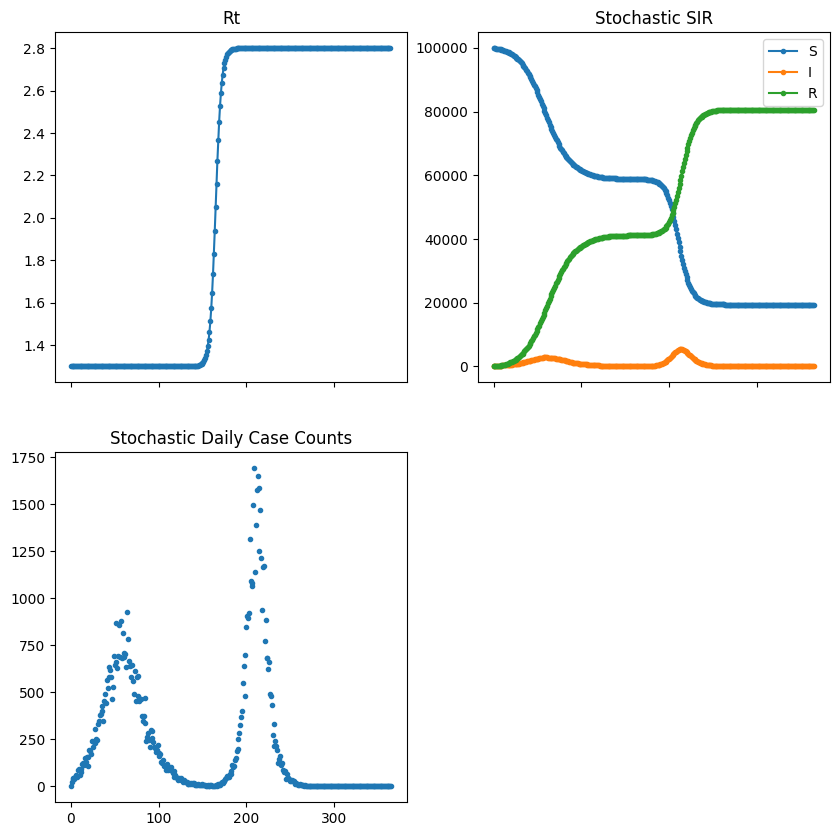

In [5]:
#plot sythentic data for run 0
file = run_dir + f"{pp}_adaptive_inflation_run_0.pkl"
eakf = open_pickle(file)

eakf.data.plot_all()

In [6]:
eakf.data.n_t

365

In [7]:
# calculate rank, percentiles, and cdfs
rank = np.zeros((100, 365))
percentiles = np.zeros((100, 365))

for run in tqdm(range(100)):
    file = run_dir + f"{pp}_adaptive_inflation_run_{run}.pkl"
    eakf = open_pickle(file)
    
    truth = eakf.data.beta * eakf.data.t_I
    post_rts = np.sort(np.array([θ.beta * θ.t_I for θ in eakf.θ_list]), axis=1)
    
    # find which index in ensemble post_rts[i-1,:] <= truth[:] < post_rts[i,:]
    idx = (post_rts.T < truth).sum(axis=0)
    
    rank[run,:] = idx

    # map from index to percentile p (smallest one where truth lives within p% CrI)
    # each ensemble member has mass 1 / eakf.m
    # for cases where the truth does not lie within idx = 0 or idx = n_ens
    n_ens = eakf.m
    percentiles[run,:] = np.maximum(1 - 2*idx/n_ens, 2*idx/n_ens - 1)  # each ensemble member has mass 1 / n_ens


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.89it/s]


### 1. Rank Histogram

A rank of 0 means that all ensemble members were strictly greater than the observation. A rank of 300 (`n_{ens} = eakf.m`) means that all ensemble members were strictly less than the observation. To determine which day $t$ has the most uniform rank histogram, we compute the following score:
$$
\operatorname{SCORE}_t = \sum_{i=0}^{n_{ens}} \left|~r_t(i) - \frac{n_{runs}}{n_{ens} + 1} \right|
$$
where $r_t(i)$ is the number of runs that had a rank of $i$ on day $t$.

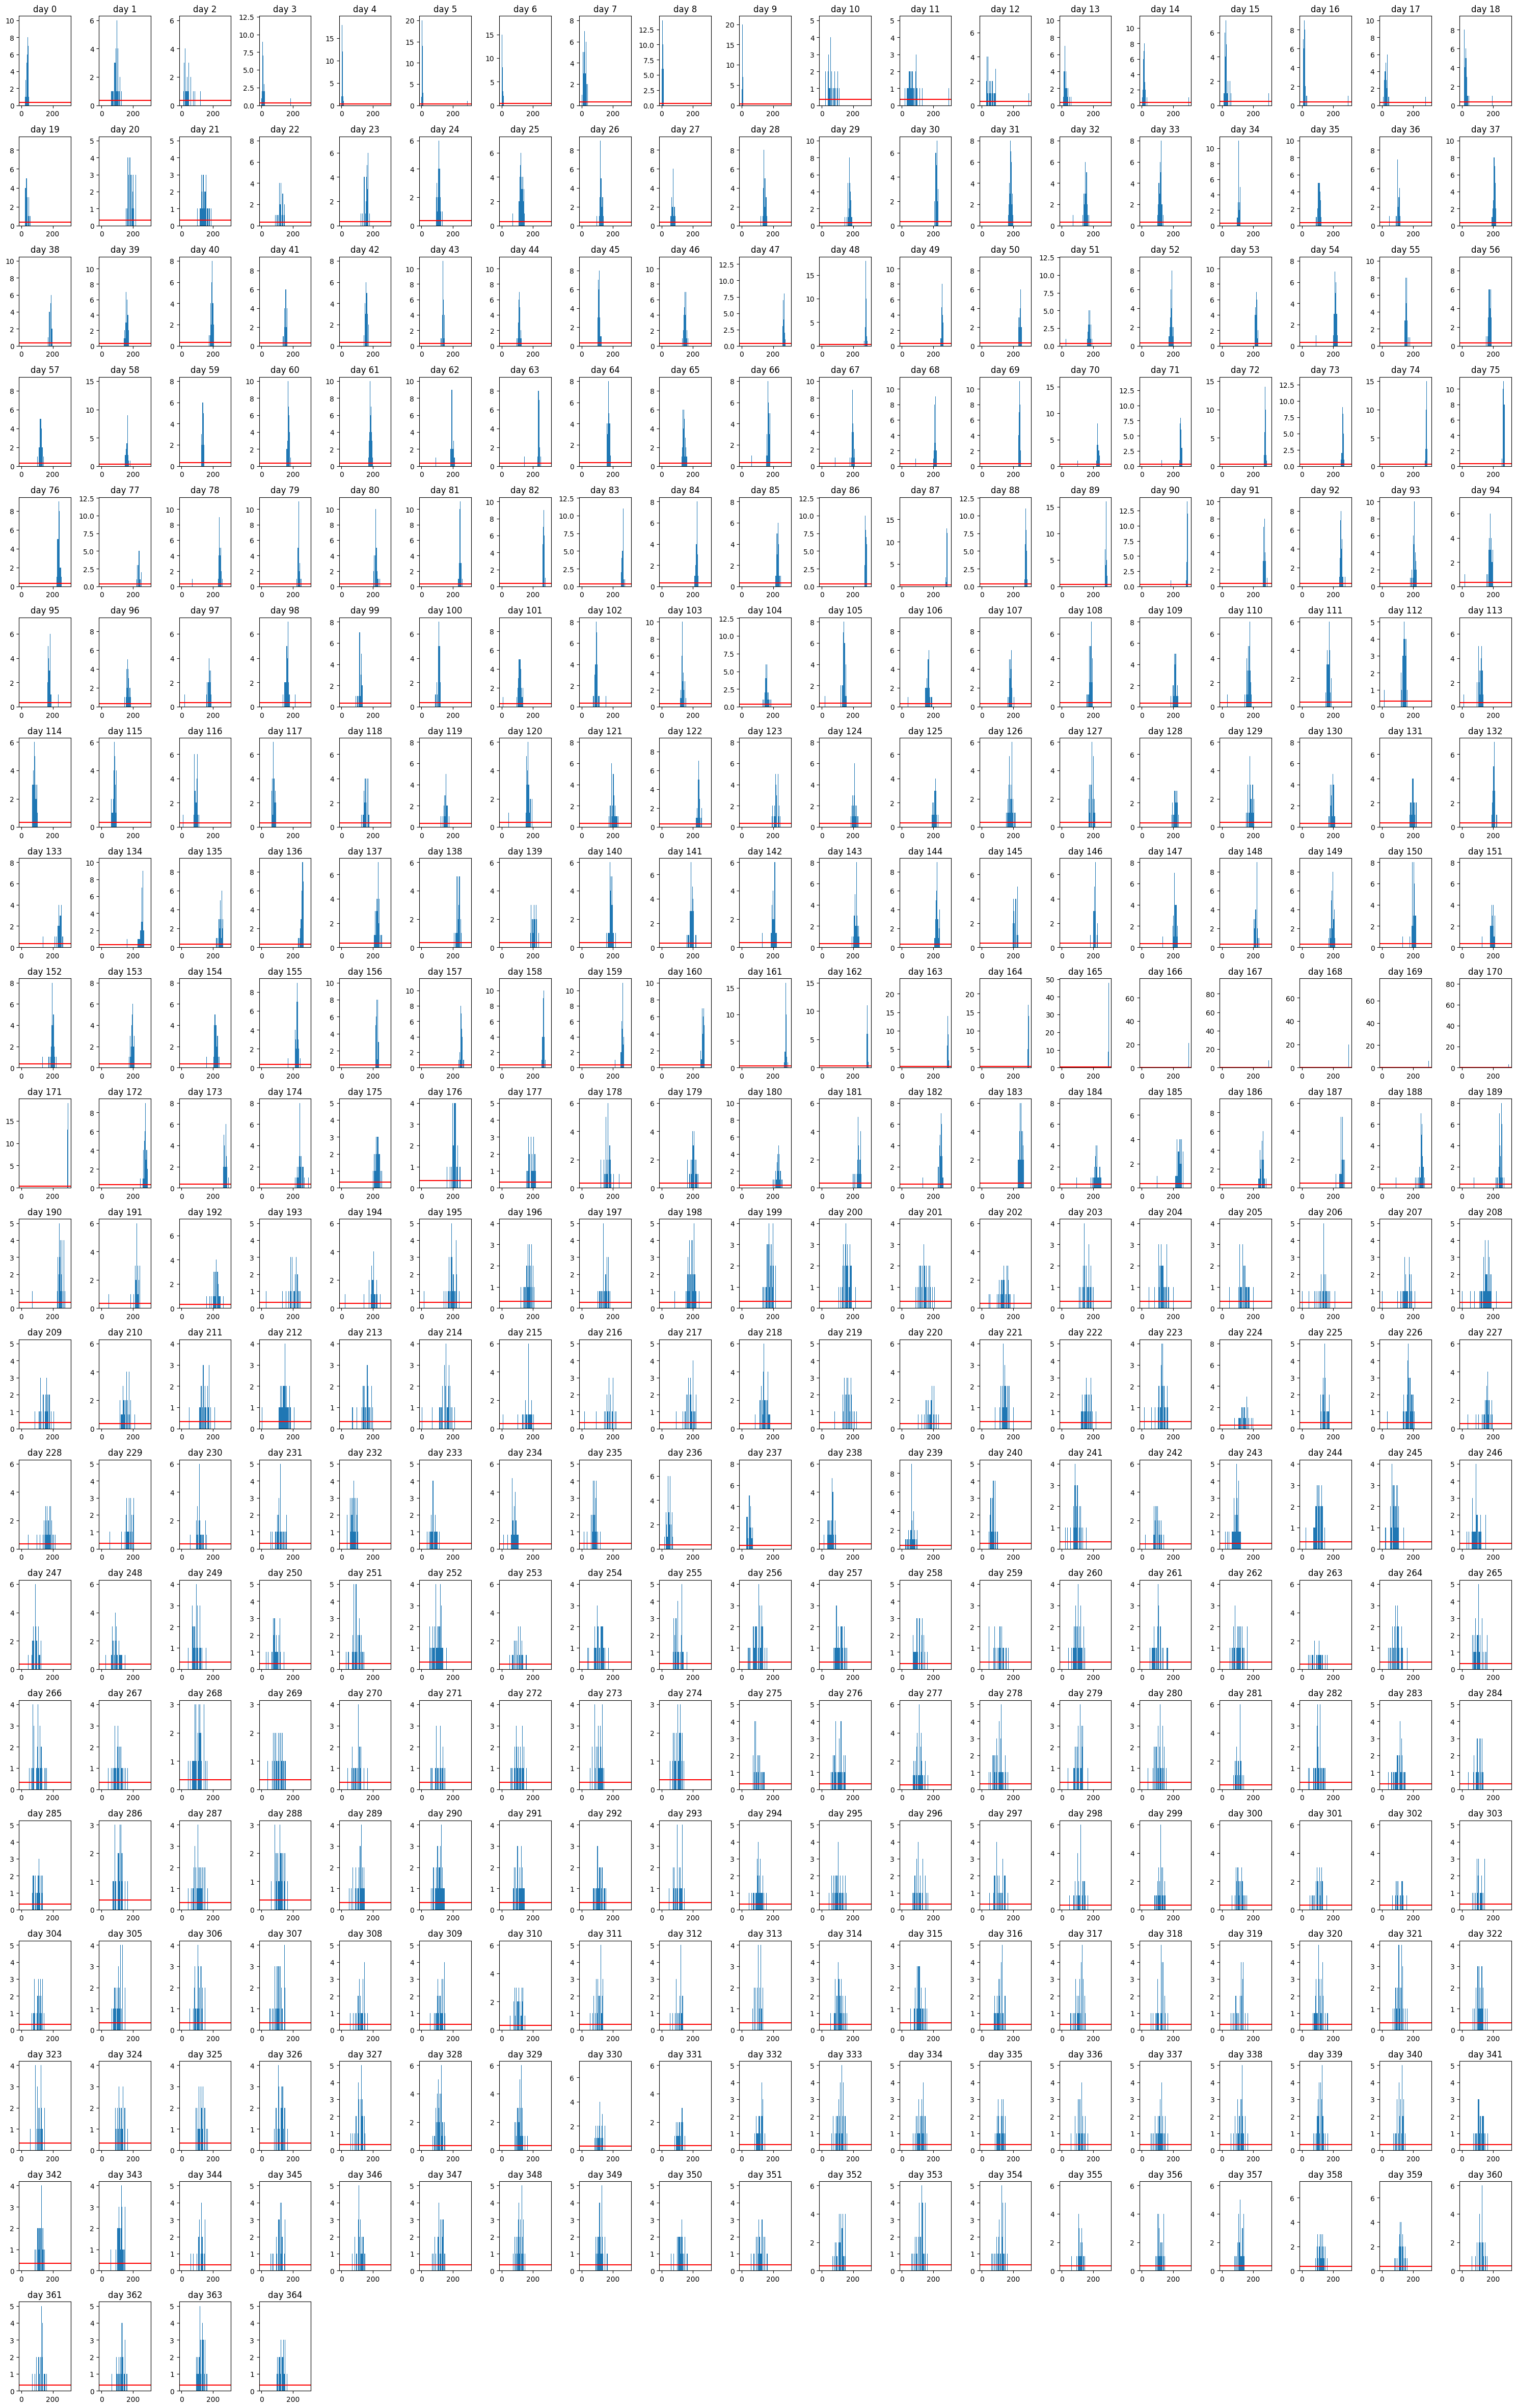

In [8]:
p_list = np.arange(.025, 1, .025)

nrow = 20
ncol = 19
fig_width = 30
fig_height = fig_width * (nrow / ncol) * 1.5

fig, axs = plt.subplots(nrow, ncol, figsize=(fig_width, fig_height))

n_ens = eakf.m
n_runs = 100

scores = []
for i, ax in enumerate(axs.flat):
    if i > 364:
        ax.axis("off")
    else:
        hist = ax.hist(rank[:,i], bins=np.arange(0, eakf.m + 1))
        ax.axhline(y = n_runs/eakf.m, color = 'r', linestyle = '-')  # uniform line
        ax.set_title(f"day {i}")
        # compute rank histogram score
        scores.append(np.sum(np.abs(hist[0] - n_runs/(eakf.m + 1))))

plt.tight_layout()
plt.show()

In [9]:
rank_hist_scores = np.argsort(scores)
np.argsort(scores)[:5]

array([262, 261, 252, 267, 279])

### 2. Reliability plot
To determine which day  $t$ has the reliabilty plot closest to the identity line we compute the residual sum of squares:
$$
\operatorname{SCORE}_t = \sum_{i=1}^n (p(i) - f_t(p(i)))^2
$$
where $p(i) = 2 (i-1)/n_{ens}$ is the credible level $(0 \leq p_i \leq 1)$ and $f_t$ is the fraction of runs where the truth lies within the $p_i$-th credible interval on day $t$.

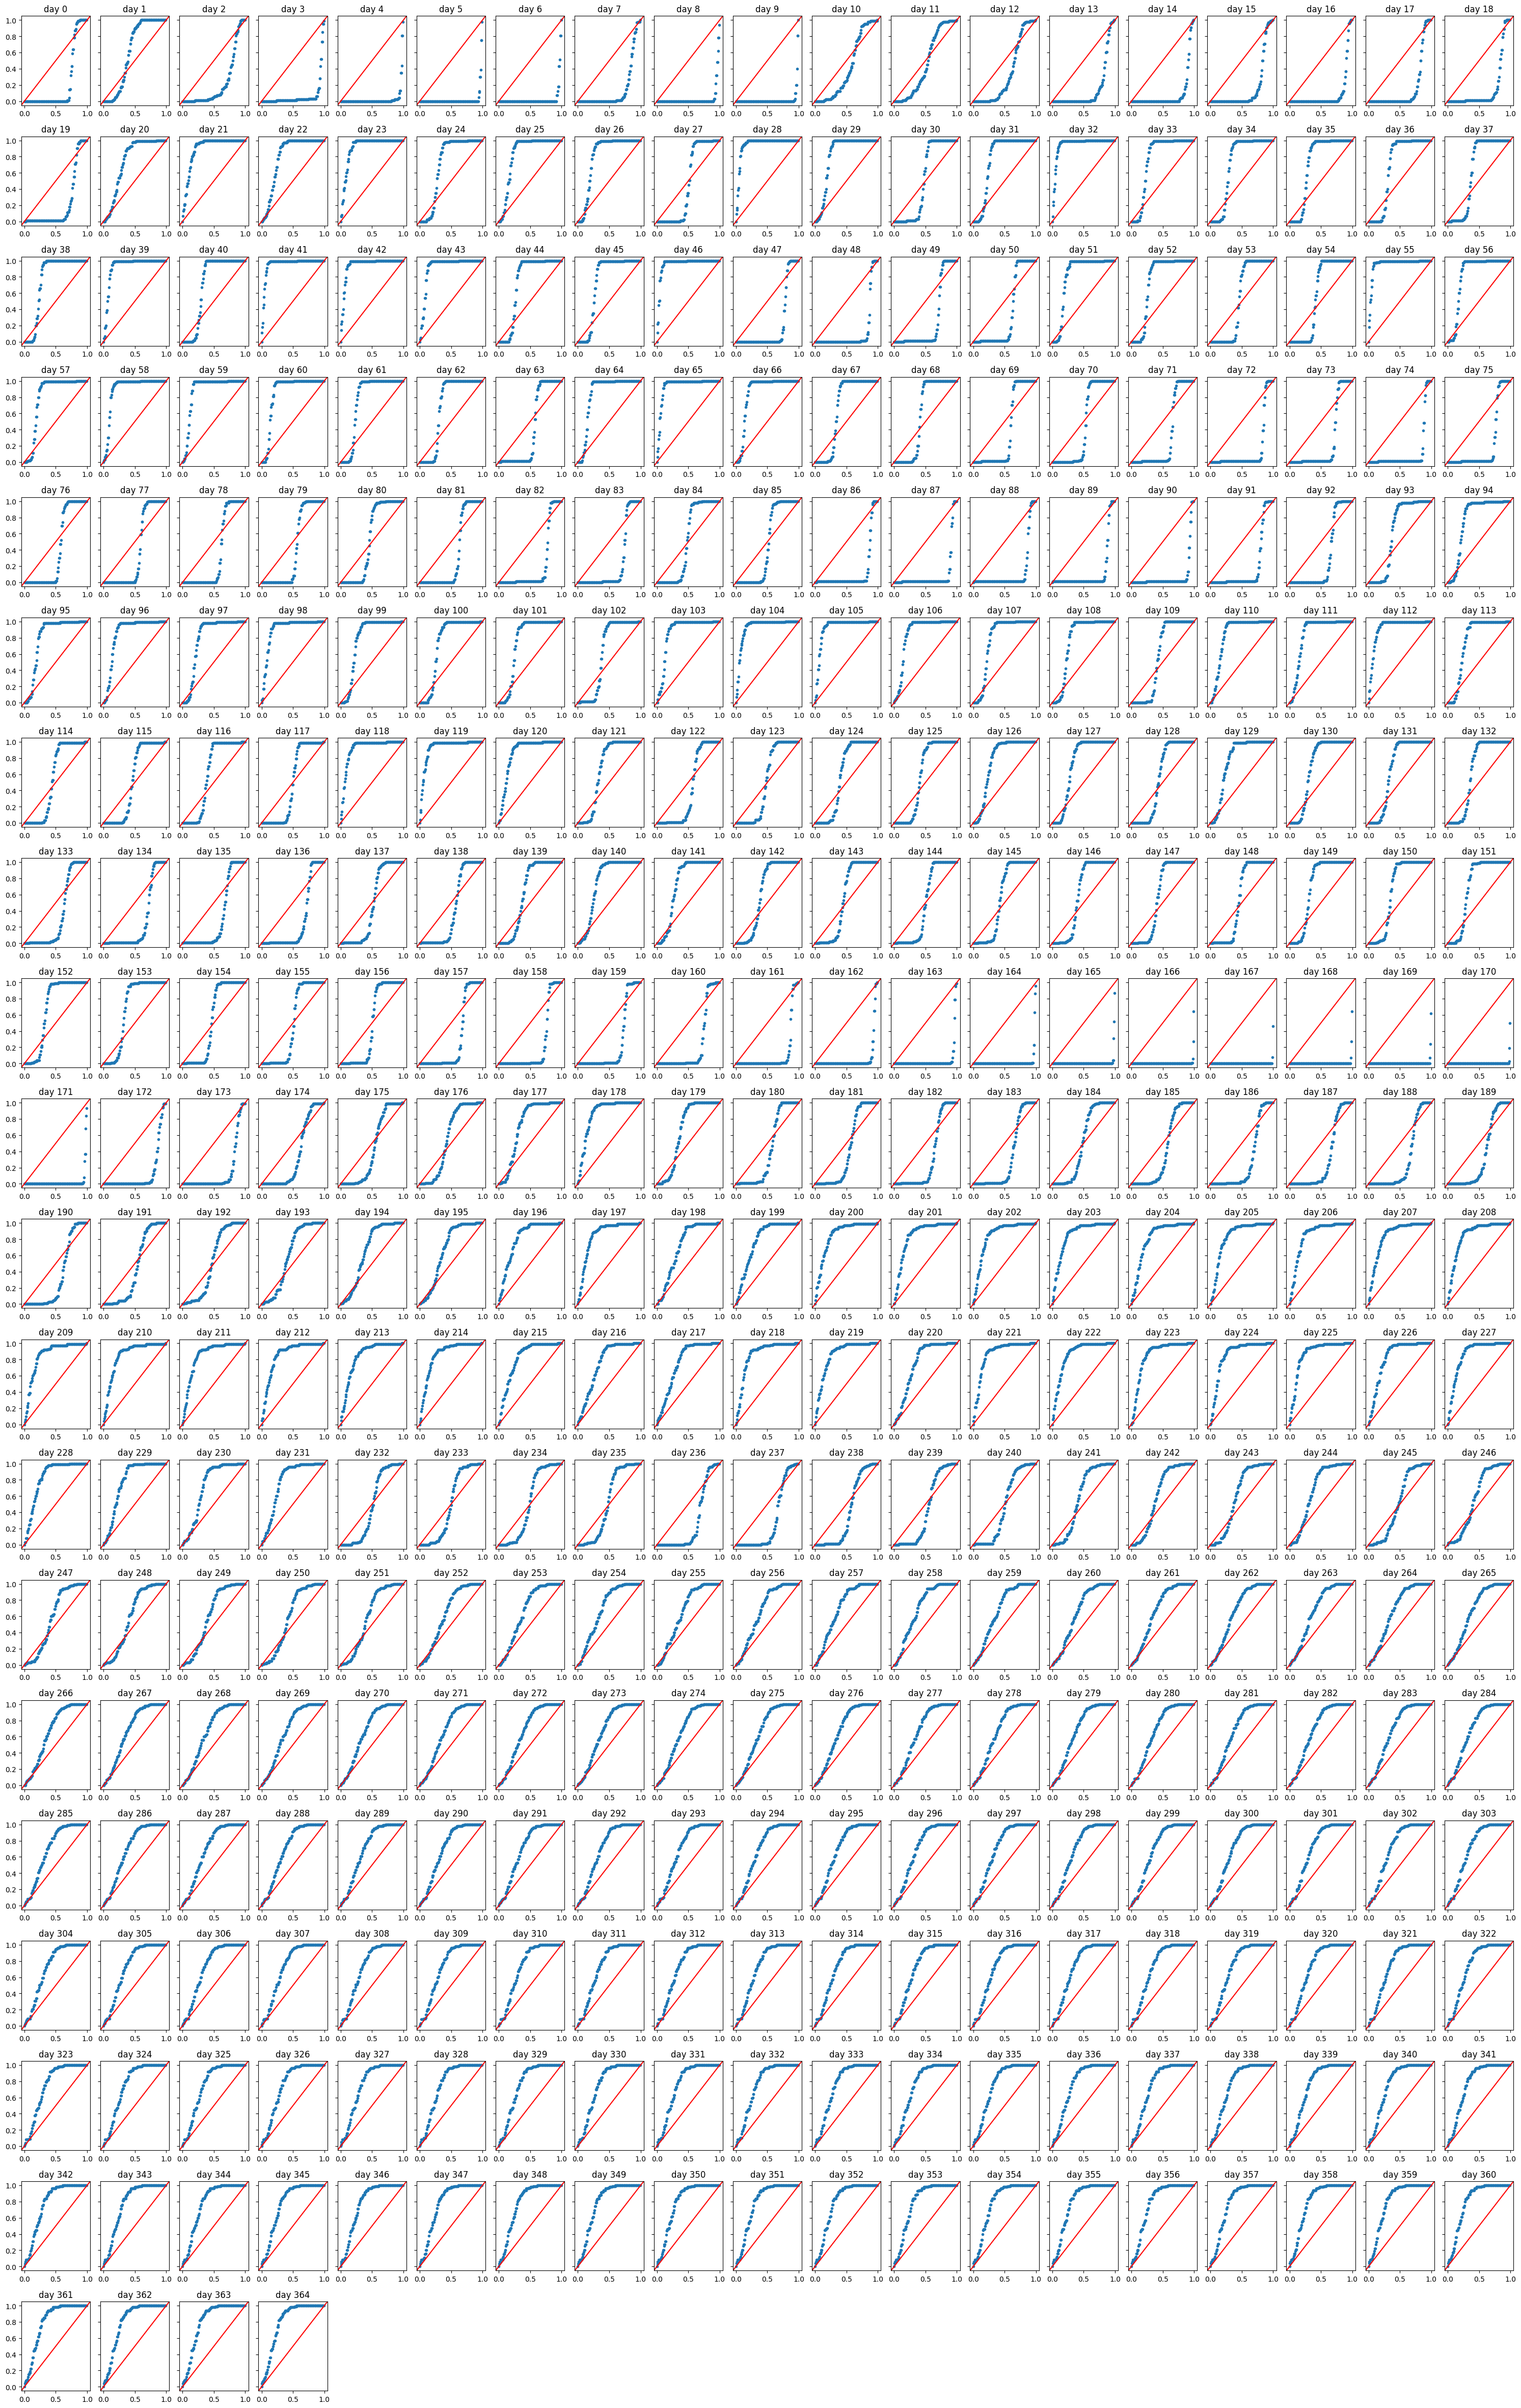

In [10]:
n_ens = eakf.m
p_list = np.arange(0, 1, 2/n_ens)

nrow = 20
ncol = 19
fig_width = 30
fig_height = fig_width * (nrow / ncol) * 1.5

fig, axs = plt.subplots(nrow, ncol, figsize=(fig_width, fig_height), sharey=True)

scores = []
for i, ax in enumerate(axs.flat):
    if i > 364:
        ax.axis("off")
    else:
        cdf = np.cumsum(np.histogram(percentiles[:,i], bins=p_list)[0]/100)
        cdf = np.insert(cdf, 0, 0.)
        ax.plot(p_list, cdf, '.')
        ax.axline((0, 0), (1, 1), color='r')
        ax.set_title(f"day {i}")
        scores.append(np.mean((p_list - cdf) ** 2))

plt.tight_layout()
plt.show()

In [11]:
reliability_scores = np.argsort(np.array(scores))
np.argsort(np.array(scores))[:5]

array([ 11, 245,  10, 247, 246])

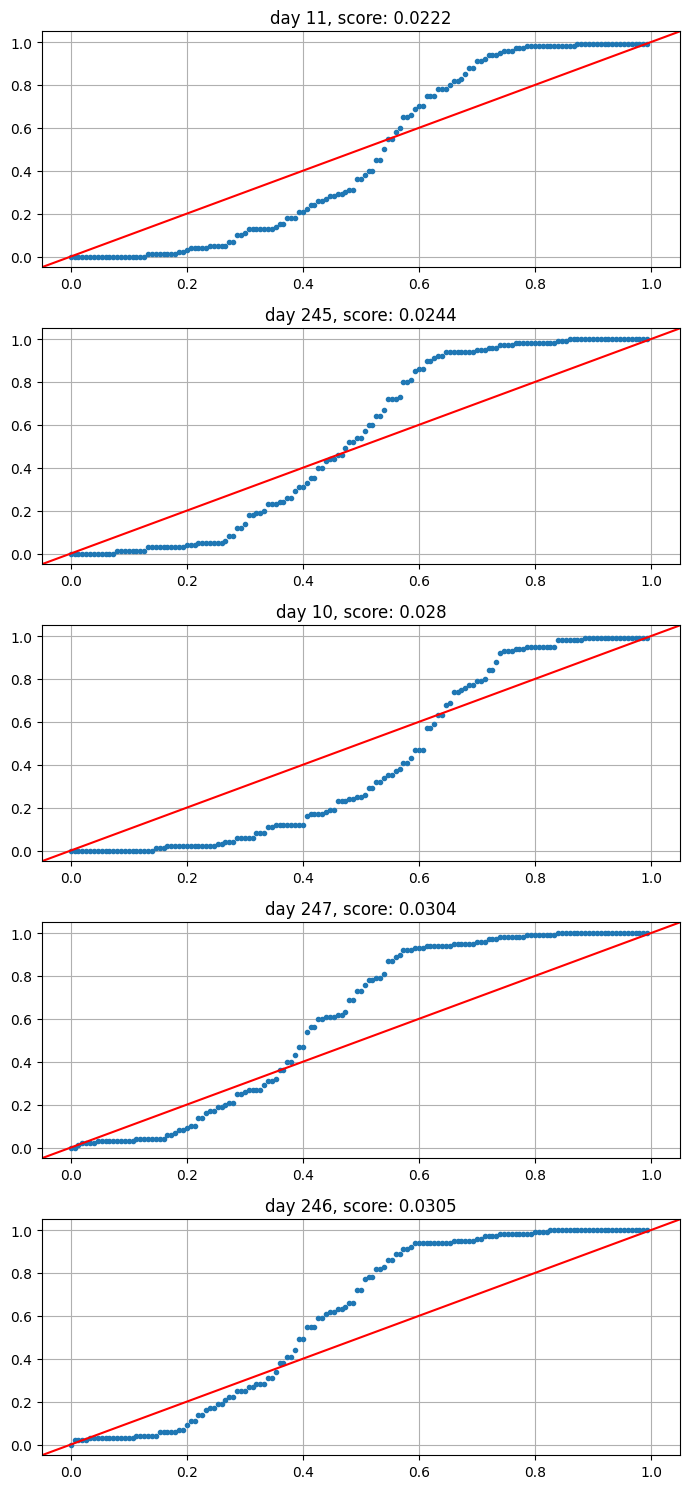

In [12]:
best_scores_idx = np.argsort(np.array(scores))[:5]

fig, axs = plt.subplots(5, figsize=(7, 15))
for i, ax in enumerate(axs.flat):
    ax.plot(p_list, [(percentiles[:,best_scores_idx[i]] < p).sum() / 100 for p in p_list], '.')
    ax.axline((0, 0), (1, 1), color='r')
    ax.set_title(f"day {best_scores_idx[i]}, score: {round(scores[best_scores_idx[i]], 4)}")
    ax.grid()

plt.tight_layout()
plt.show()

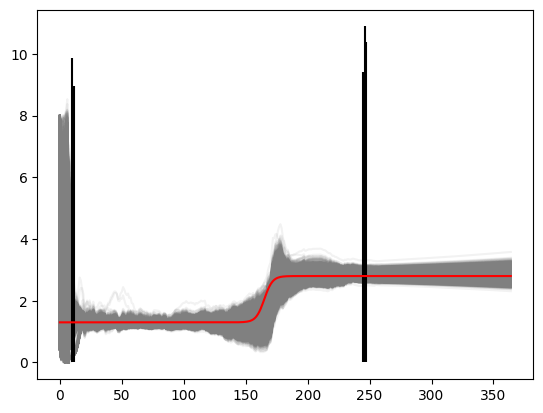

In [13]:
fig, ax = plt.subplots()

for run in range(100):
    file = run_dir + f"{pp}_adaptive_inflation_run_{run}.pkl"
    eakf = open_pickle(file)
    post_rts = np.array([θ.beta * θ.t_I for θ in eakf.θ_list])
    ax.plot(post_rts, color='gray', alpha=0.1)

for day in best_scores_idx:
    ax.vlines(day, 0.01, ax.get_ylim()[1], color='black', label='last epi day')
ax.plot(truth, color='r')

In [14]:
blah_list = []

for run in range(100):
    file = run_dir + f"{pp}_adaptive_inflation_run_{run}.pkl"
    eakf = open_pickle(file)
    post_rts = np.array([θ.beta * θ.t_I for θ in eakf.θ_list])
    blah_list.append(post_rts[best_scores_idx,:])

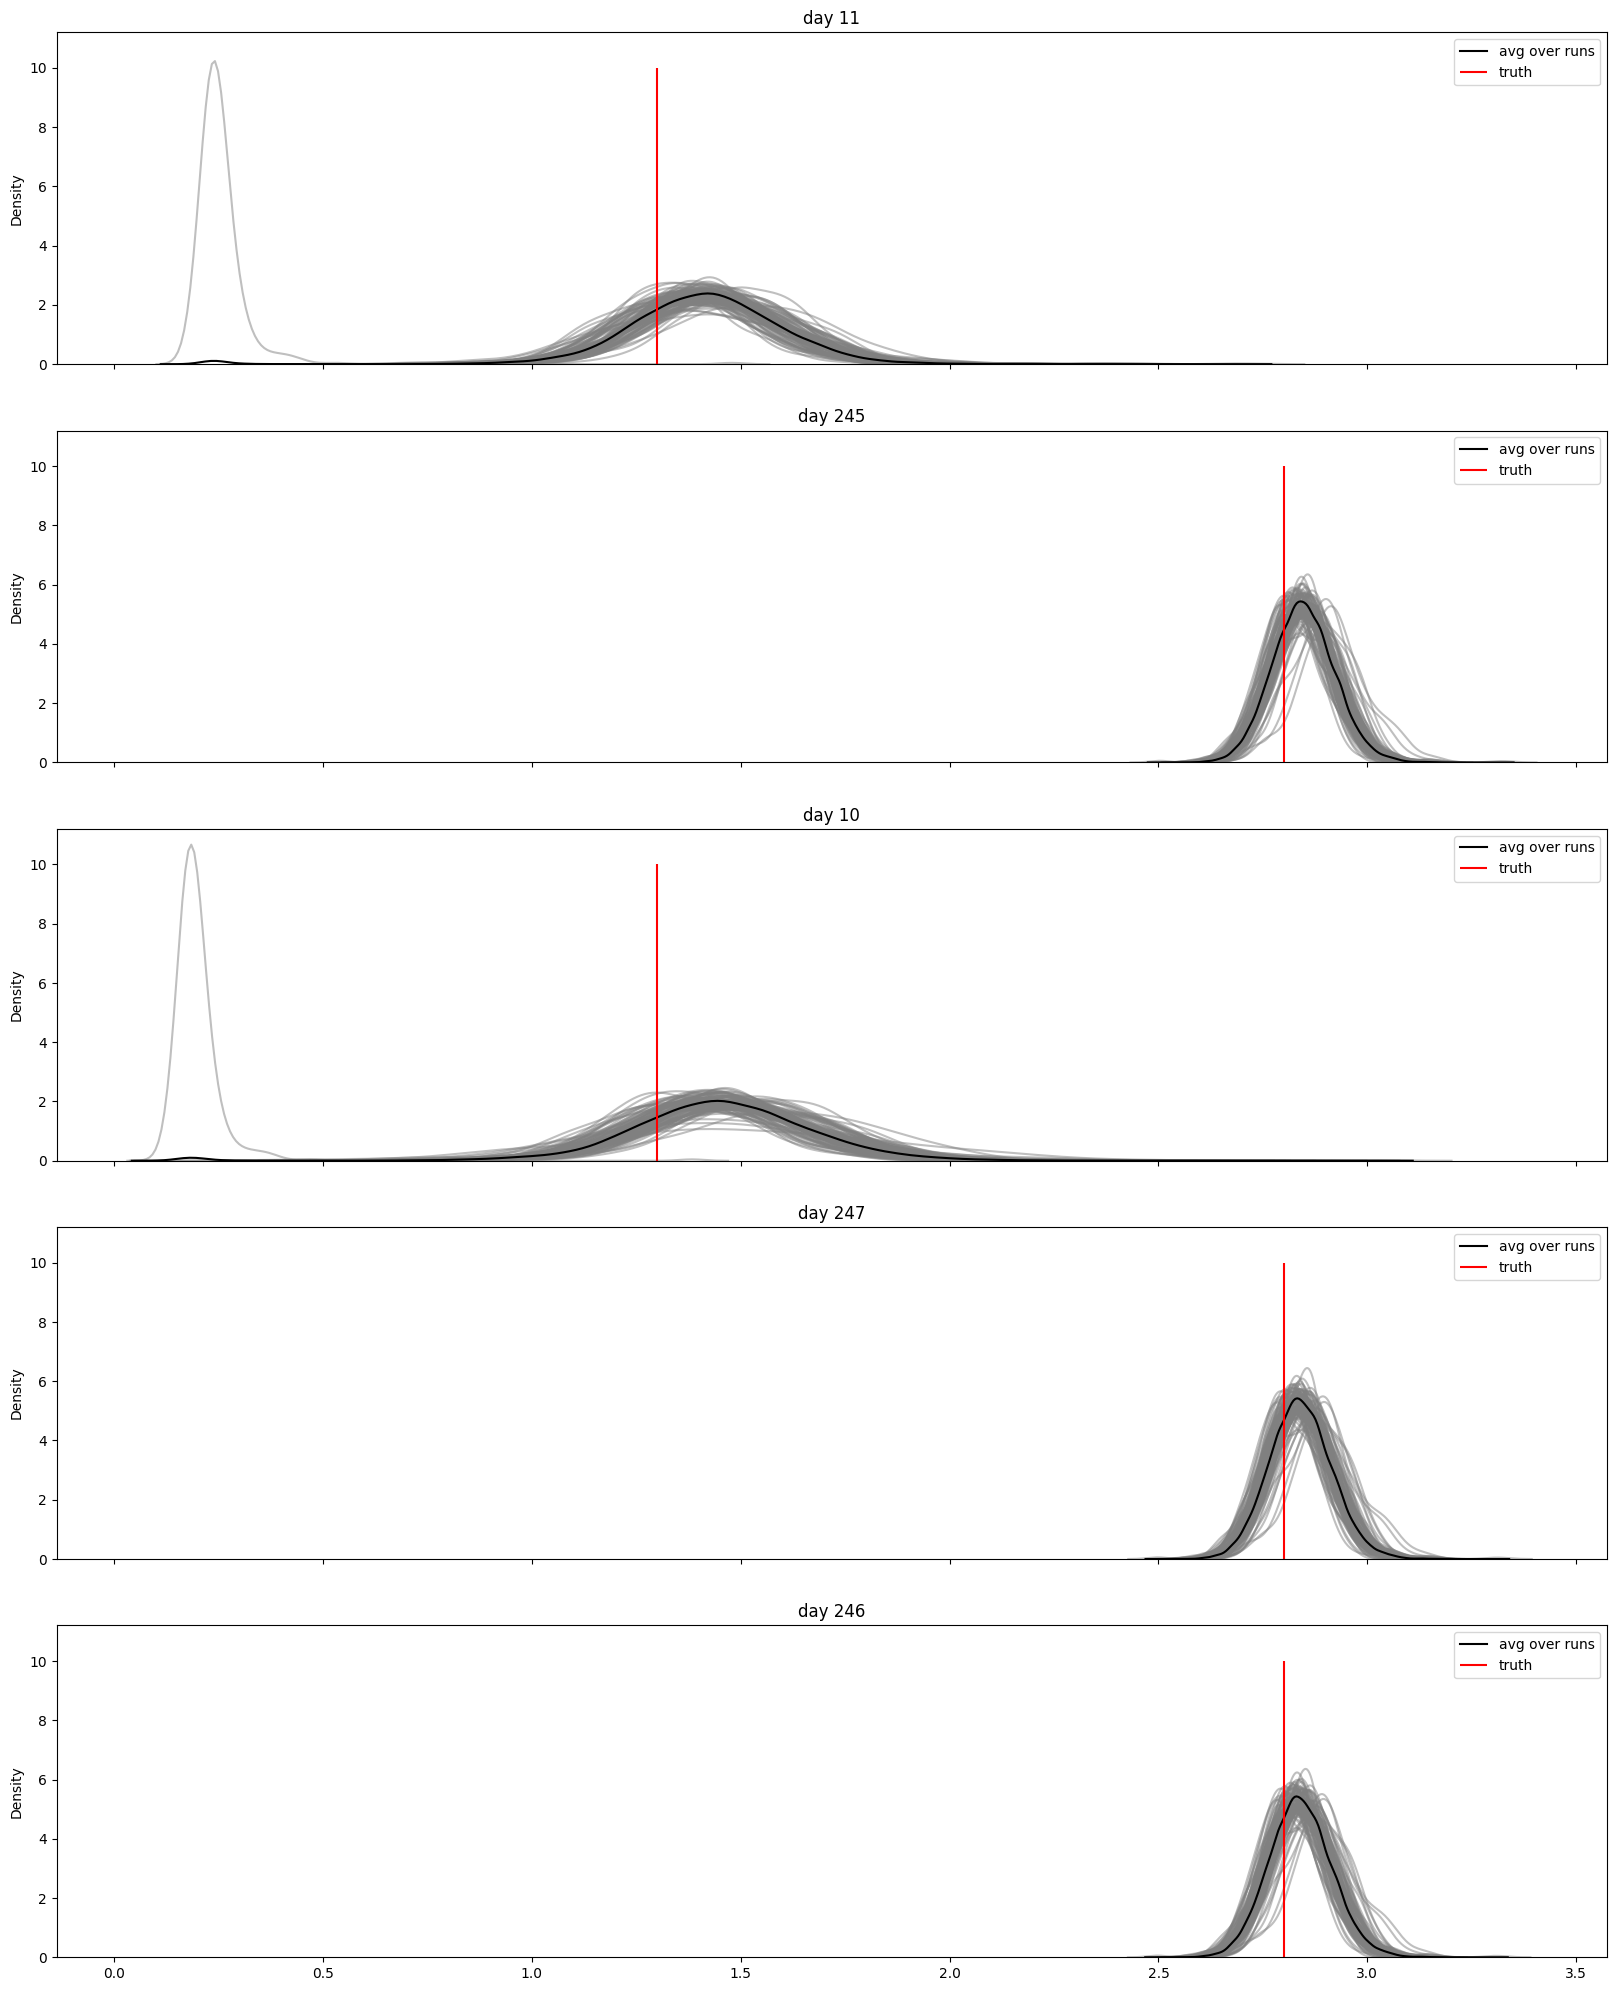

In [15]:
fig, axs = plt.subplots(5, figsize=(20,25), sharex = True, sharey=True)
for i, ax in enumerate(axs.flat):
    data = np.array(blah_list)[:,i,:]
    for j in range(data.shape[0]):  # plot kde for each run on day i
        sns.kdeplot(data=data[j,:], color='gray', alpha=0.5, ax=ax)
    sns.kdeplot(data=data[:,:].flatten(), color='black', ax=ax, label='avg over runs')
    ax.set_title(f"day {best_scores_idx[i]}")
    ax.vlines(truth[best_scores_idx[i]], 0, 10, color='red', label='truth')
    ax.legend()

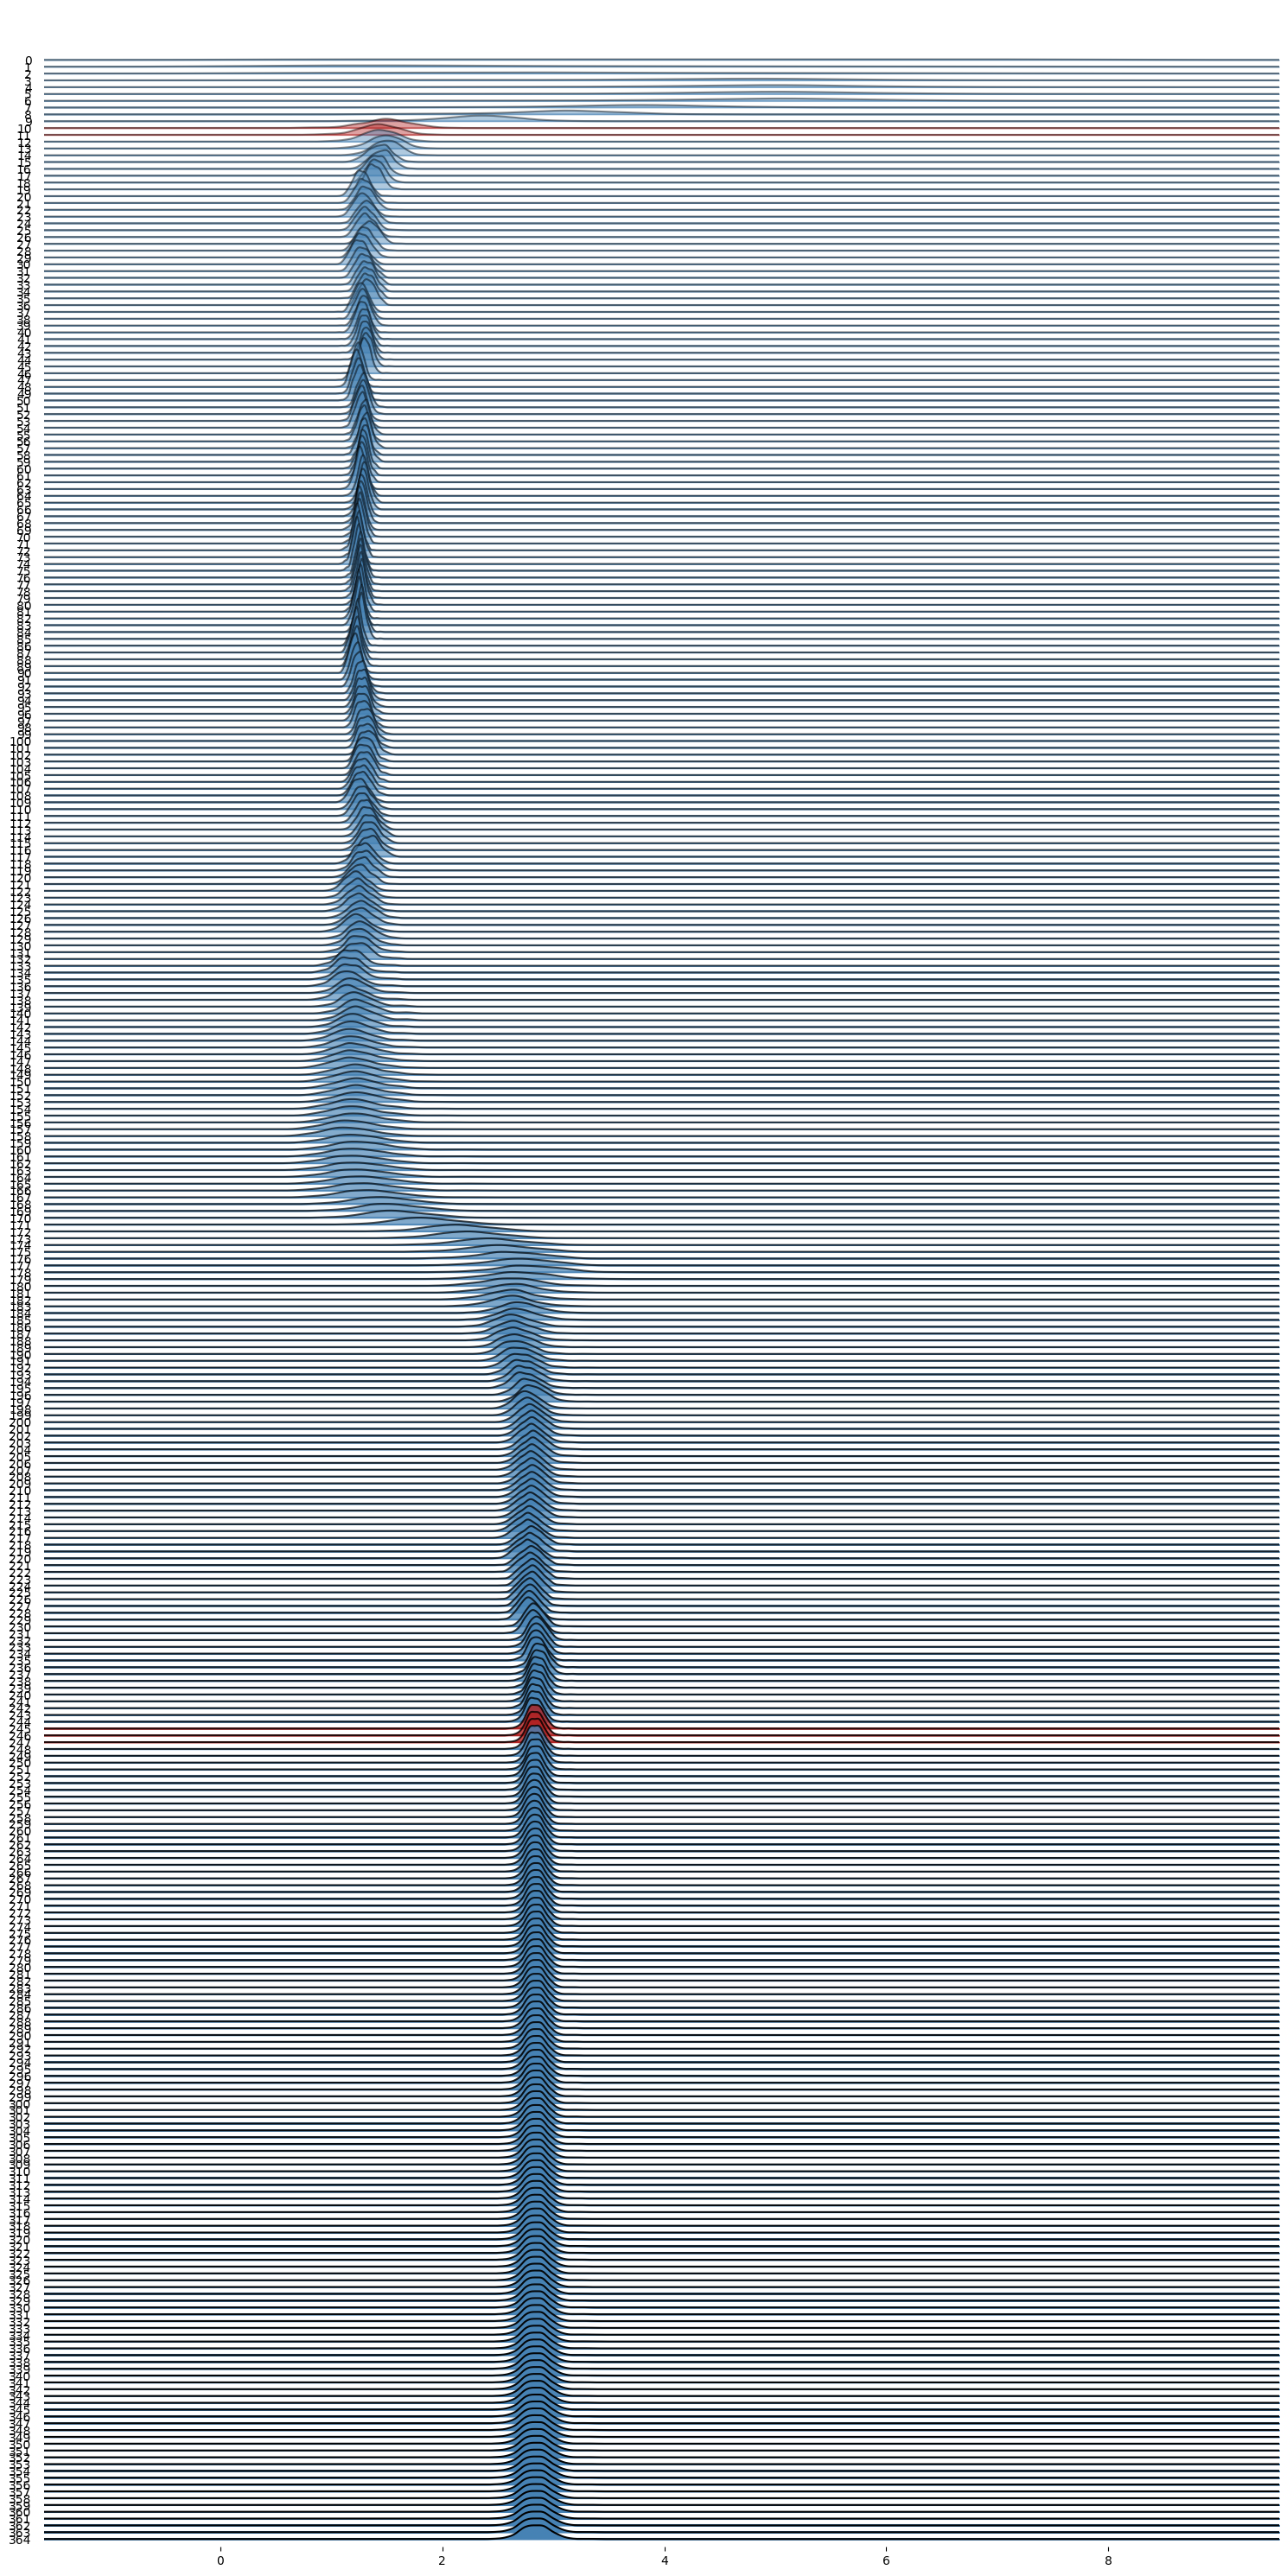

In [16]:
import joypy

df = pd.DataFrame(post_rts.T)

colors = ["#4682B4"] * 365
for idx in best_scores_idx:
    colors[idx] = "#B22222"

fig, axes = joypy.joyplot(df, fade=True, figsize=(15,30), color=colors)

#### Score based on days where the truth is exactly in the middle of the percentile
This is dumb and slow. There's probably a faster and better way to do this. How about looking in `percentiles` for days that are close to 0

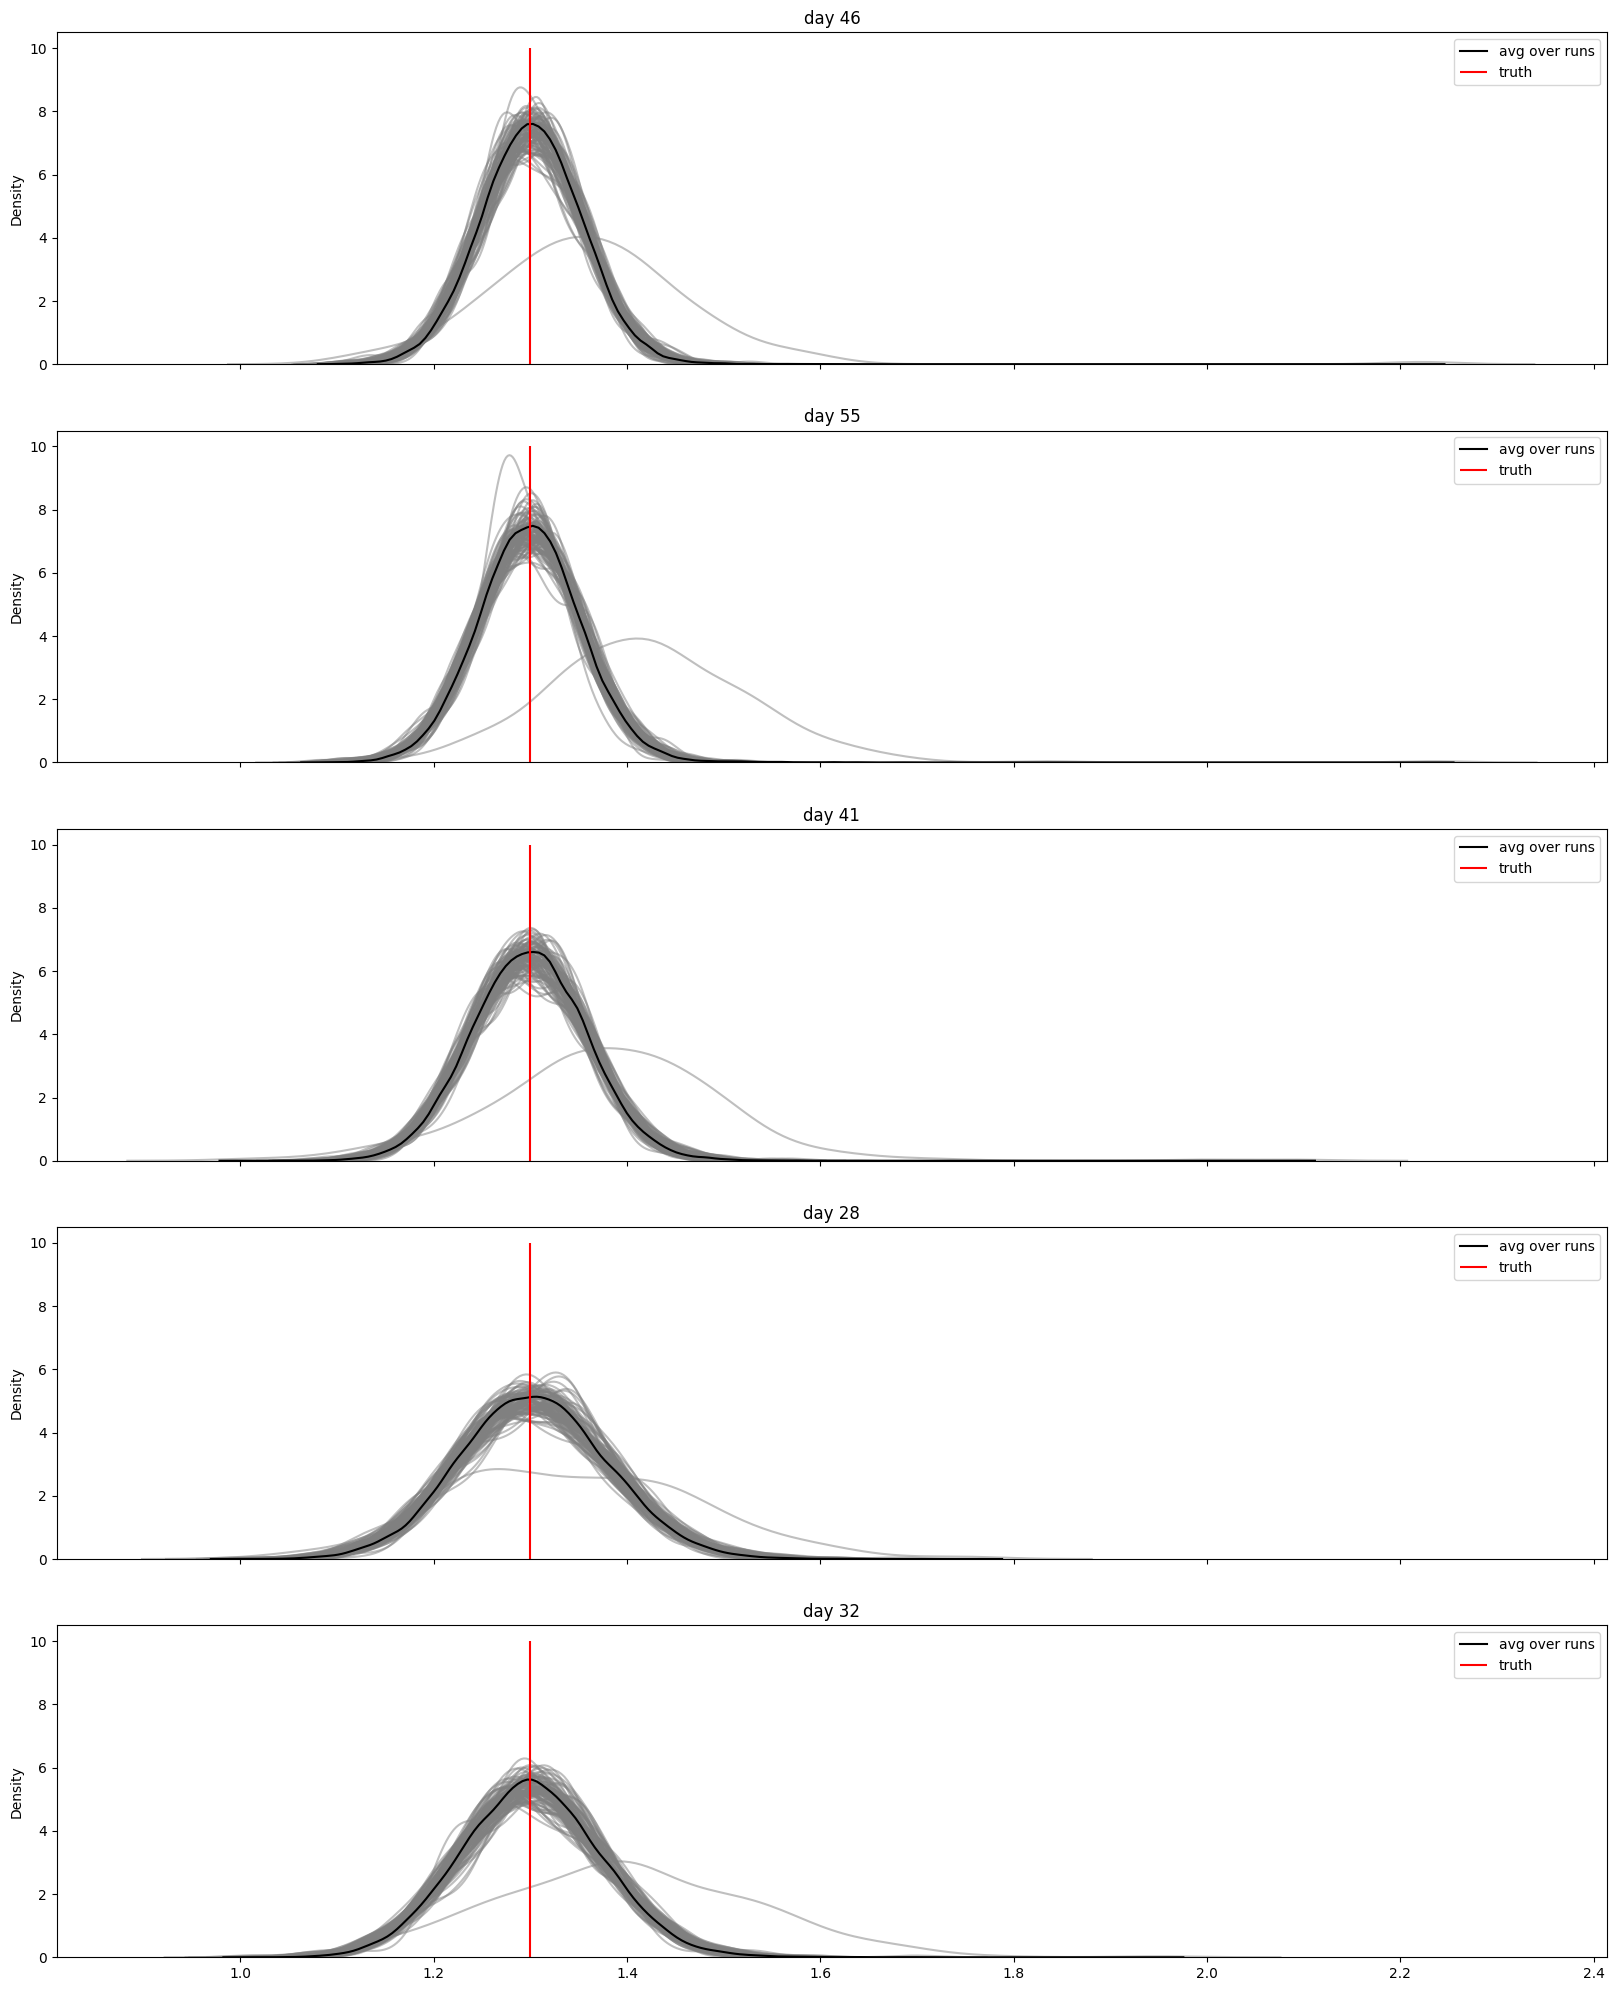

In [17]:
percentiles_mean_run = np.mean(percentiles, axis=0)
best_scores_idx = np.argsort(percentiles_mean_run)[:5]

blah_list = []

for run in range(100):
    file = run_dir + f"{pp}_adaptive_inflation_run_{run}.pkl"
    eakf = open_pickle(file)
    post_rts = np.array([θ.beta * θ.t_I for θ in eakf.θ_list])
    blah_list.append(post_rts[best_scores_idx,:])

fig, axs = plt.subplots(5, figsize=(20,25), sharex = True, sharey=True)
for i, ax in enumerate(axs.flat):
    data = np.array(blah_list)[:,i,:]
    for j in range(data.shape[0]):  # plot kde for each run on day i
        sns.kdeplot(data=data[j,:], color='gray', alpha=0.5, ax=ax)
    sns.kdeplot(data=data[:,:].flatten(), color='black', ax=ax, label='avg over runs')
    ax.set_title(f"day {best_scores_idx[i]}")
    ax.vlines(truth[best_scores_idx[i]], 0, 10, color='red', label='truth')
    ax.legend()

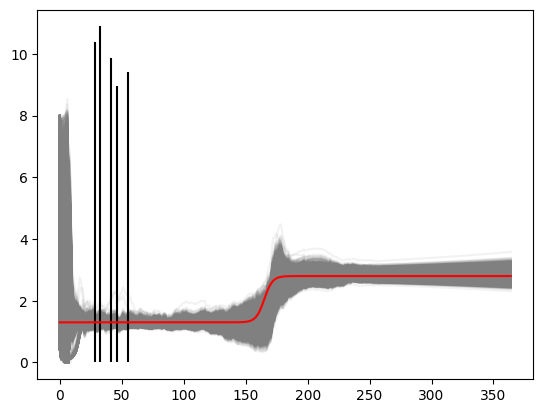

In [18]:
fig, ax = plt.subplots()

for run in range(100):
    file = run_dir + f"{pp}_adaptive_inflation_run_{run}.pkl"
    eakf = open_pickle(file)
    post_rts = np.array([θ.beta * θ.t_I for θ in eakf.θ_list])
    ax.plot(post_rts, color='gray', alpha=0.1)

for day in best_scores_idx:
    ax.vlines(day, 0.01, ax.get_ylim()[1], color='black', label='last epi day')
ax.plot(truth, color='r')

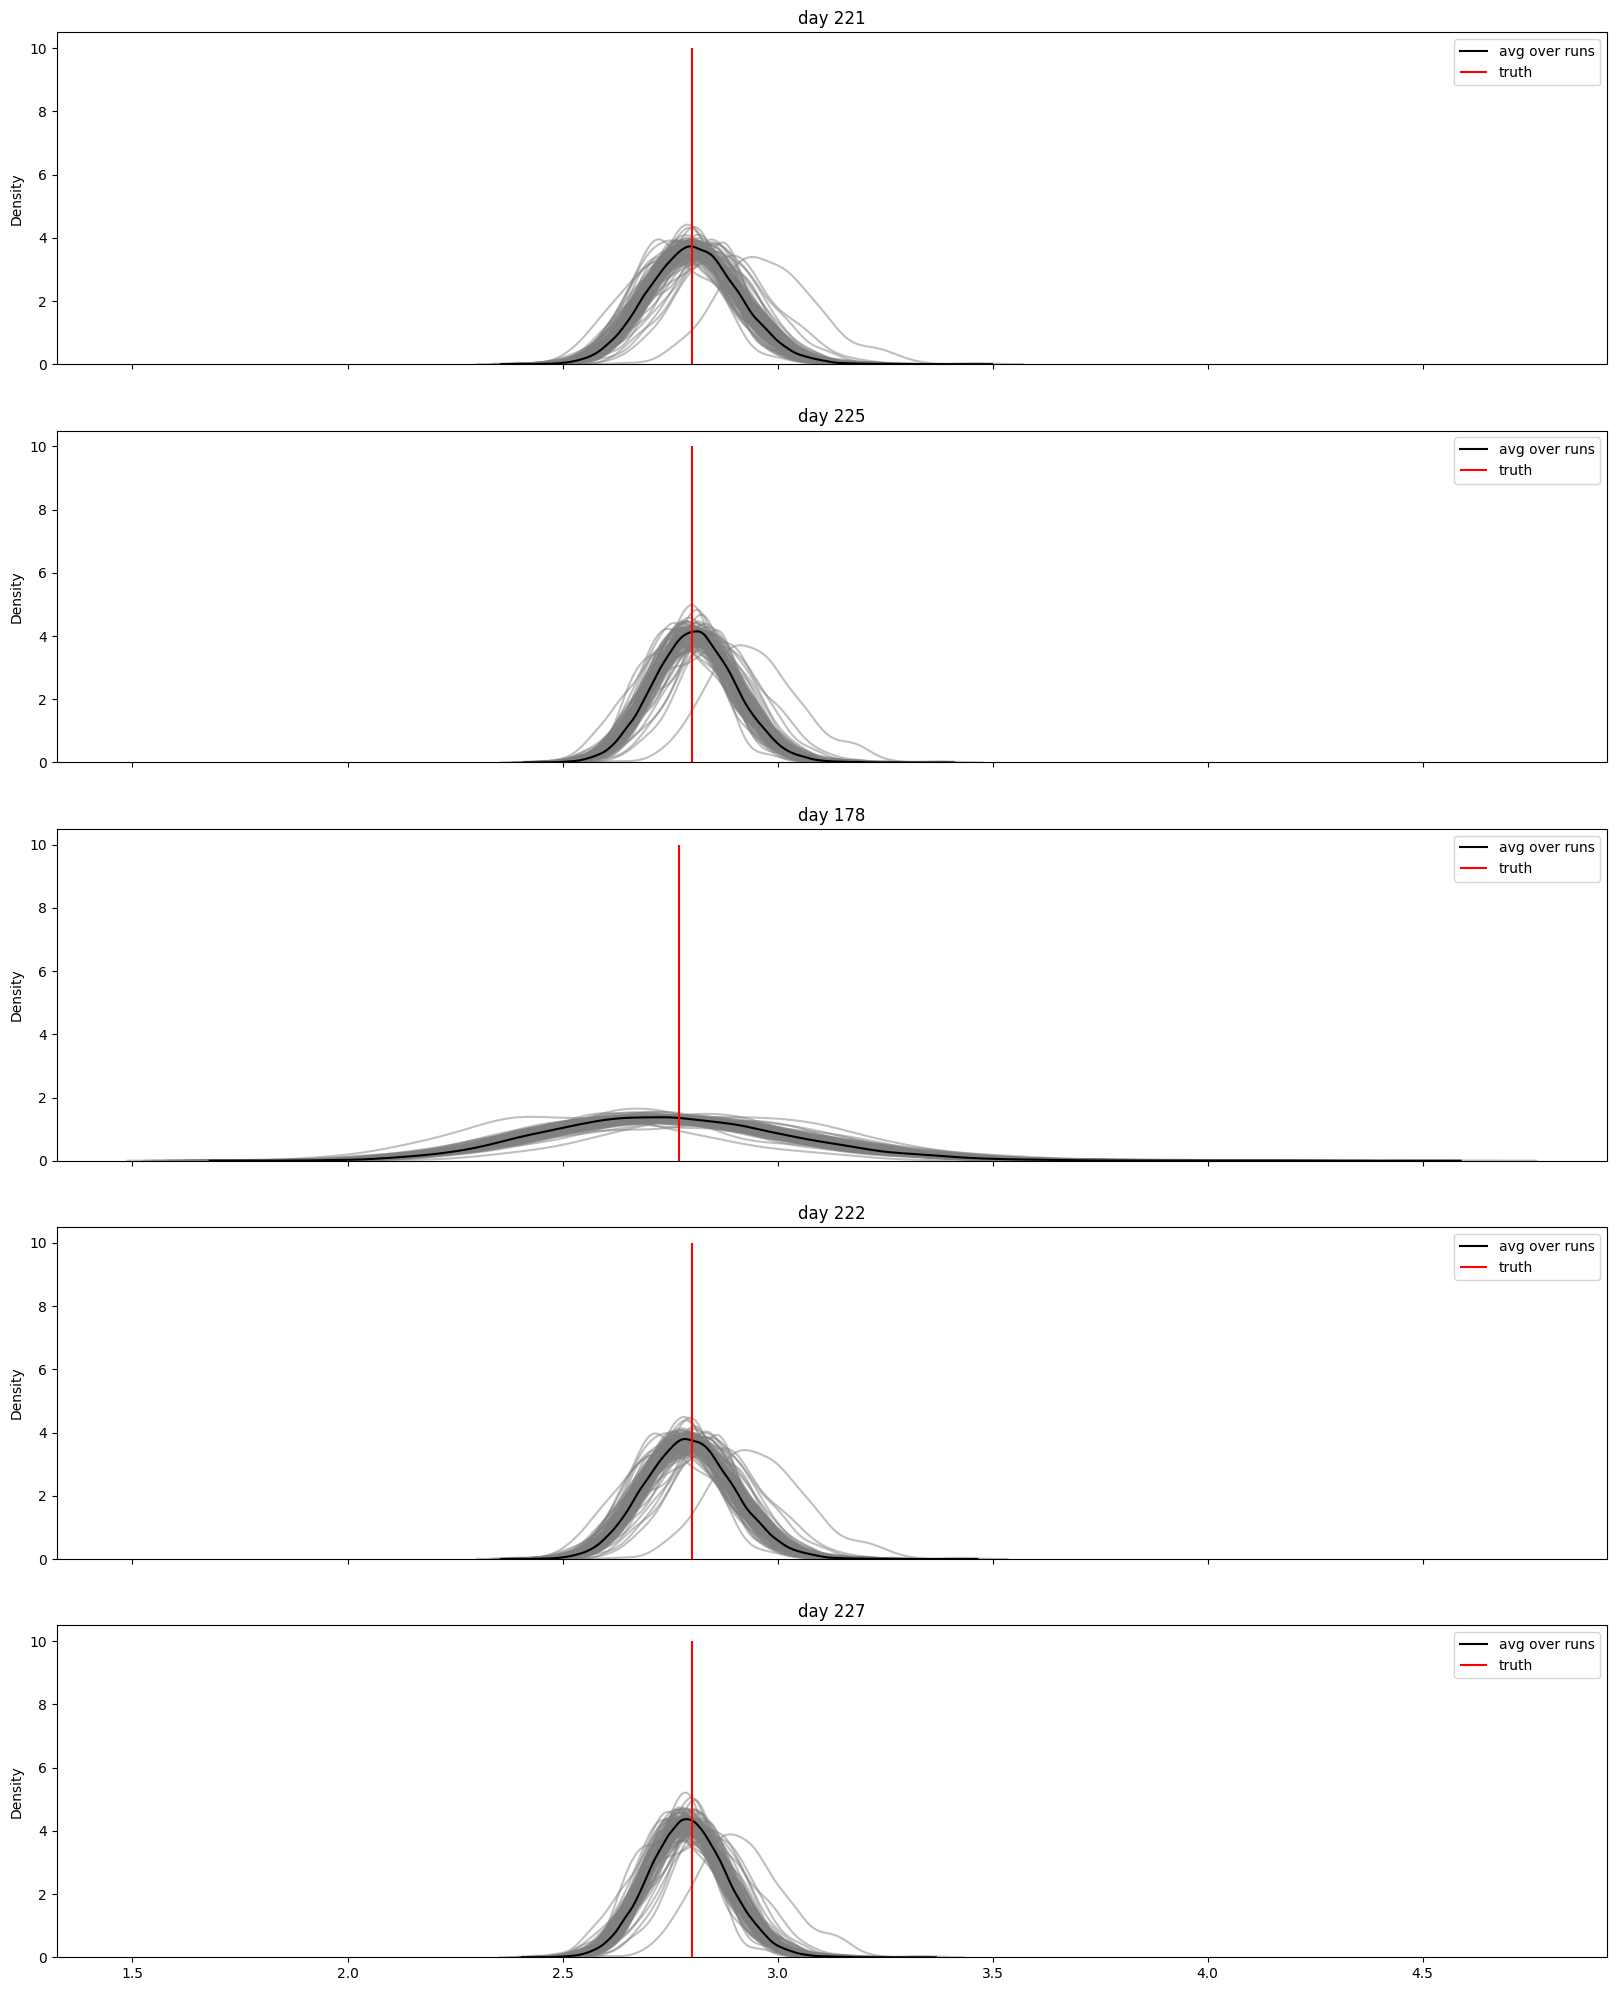

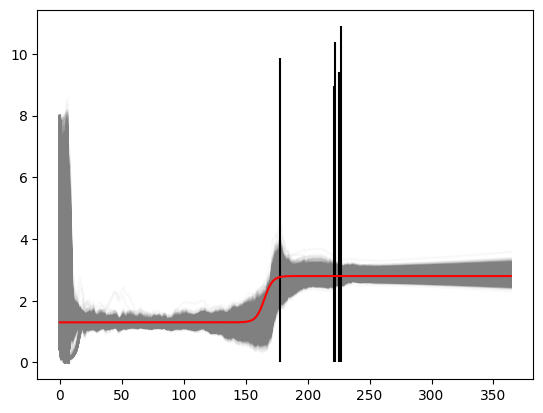

In [19]:
best_scores_after_midpoint_idx = eakf.data.midpoint + np.argsort(percentiles_mean_run[eakf.data.midpoint:])[:5]

blah_list = []

for run in range(100):
    file = run_dir + f"{pp}_adaptive_inflation_run_{run}.pkl"
    eakf = open_pickle(file)
    post_rts = np.array([θ.beta * θ.t_I for θ in eakf.θ_list])
    blah_list.append(post_rts[best_scores_after_midpoint_idx,:])

fig, axs = plt.subplots(5, figsize=(20,25), sharex = True, sharey=True)
for i, ax in enumerate(axs.flat):
    data = np.array(blah_list)[:,i,:]
    for j in range(data.shape[0]):  # plot kde for each run on day i
        sns.kdeplot(data=data[j,:], color='gray', alpha=0.5, ax=ax)
    sns.kdeplot(data=data[:,:].flatten(), color='black', ax=ax, label='avg over runs')
    ax.set_title(f"day {best_scores_after_midpoint_idx[i]}")
    ax.vlines(truth[best_scores_after_midpoint_idx[i]], 0, 10, color='red', label='truth')
    ax.legend()

fig, ax = plt.subplots()

for run in range(100):
    file = run_dir + f"{pp}_adaptive_inflation_run_{run}.pkl"
    eakf = open_pickle(file)
    post_rts = np.array([θ.beta * θ.t_I for θ in eakf.θ_list])
    ax.plot(post_rts, color='gray', alpha=0.05)

for day in best_scores_after_midpoint_idx:
    ax.vlines(day, 0.01, ax.get_ylim()[1], color='black', label='last epi day')
ax.plot(truth, color='r')


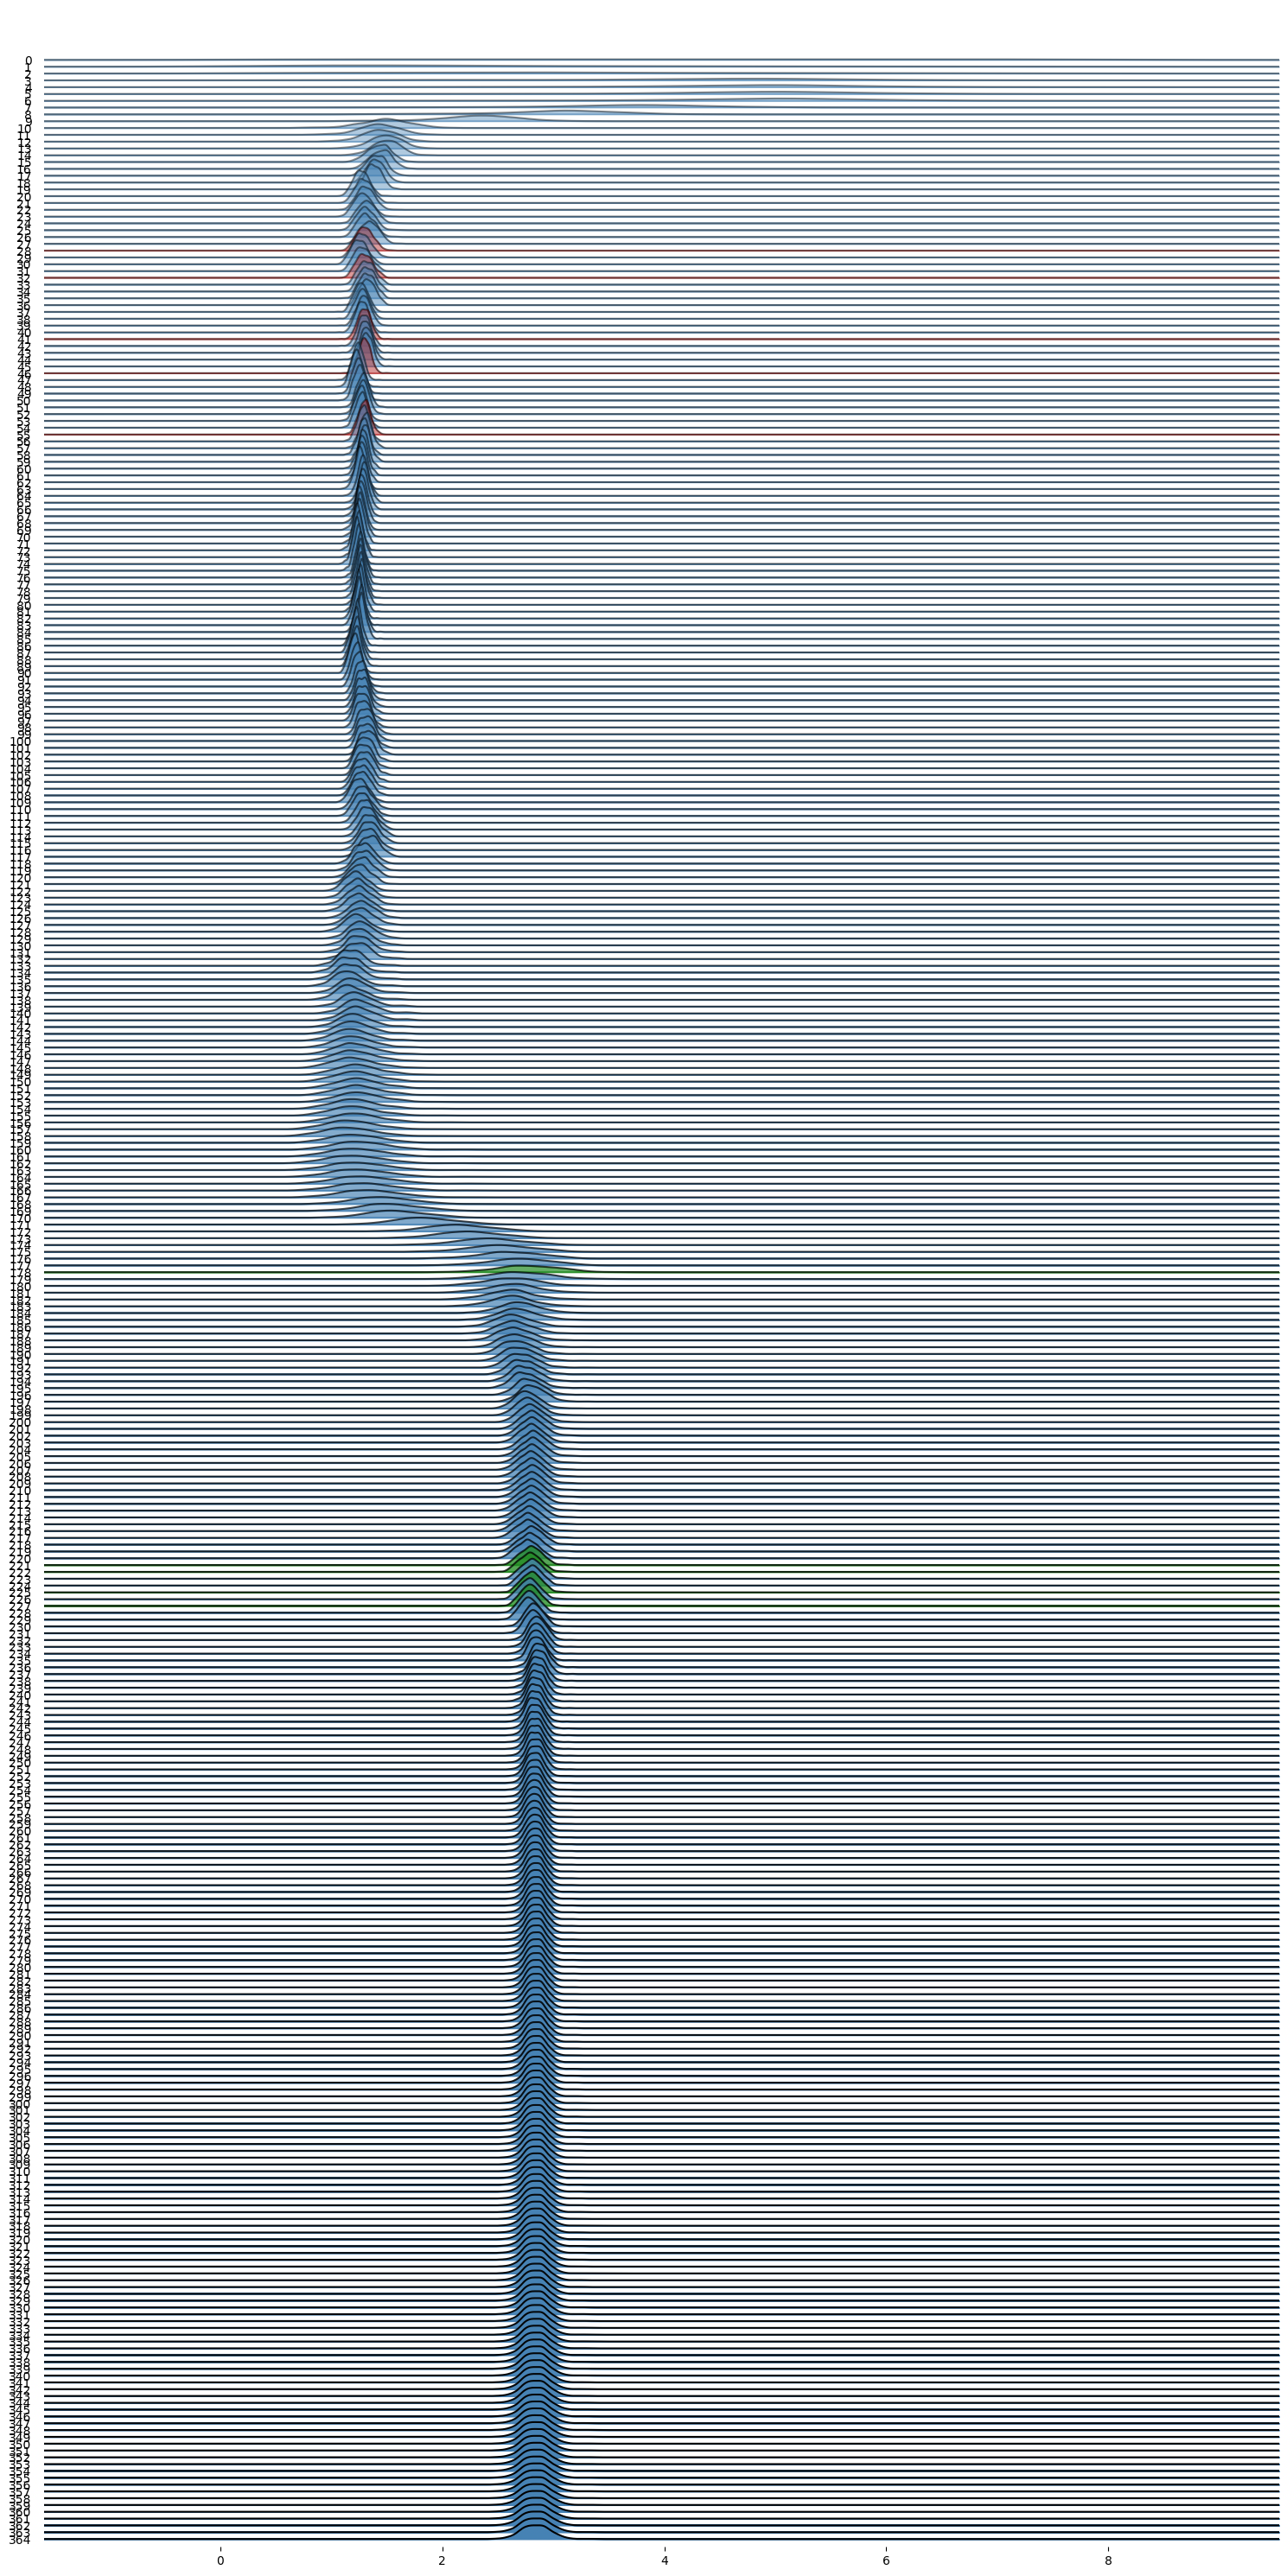

In [20]:
import joypy

df = pd.DataFrame(post_rts.T)

colors = ["#4682B4"] * 365
for idx in best_scores_idx:
    colors[idx] = "#B22222"
for idx in best_scores_after_midpoint_idx:
    colors[idx] = "#228B22"

fig, axes = joypy.joyplot(df, fade=True, figsize=(15,30), color=colors)

### 3. CRPS

In [21]:
def crps(observation, ensembles):
    """
    Calculate the Continuous Ranked Probability Score (CRPS).

    Parameters:
        observation (float): The observed value.
        ensembles (array_like): The posterior of the prediction. It should be 
            a 1D array representing the ensemble members of the filter on one day

    Returns:
        crps_score (float): The CRPS score.
    """
    hist, bins = np.histogram(ensembles, bins=len(np.unique(ensembles)))
    cdf = np.cumsum(hist/ensembles.shape[0])
    crps_score = 0
    for i,x in enumerate(bins[1:]):
        crps_score += (cdf[i] - np.heaviside(x-observation, 0.5))**2 * (bins[i] - bins[i-1])

    return crps_score

# Example usage:
# Suppose observation is 10 and forecasted CDF values are [0.1, 0.3, 0.5, 0.7, 0.9]
observation = truth[250]
prediction_cdf = post_rts[250,:]

# Calculate CRPS
score = crps(observation, prediction_cdf)
print("CRPS:", score)

CRPS: 0.026152252091040426


In [22]:
crps_all_runs = []
for run in tqdm(range(100)):
    file = run_dir + f"{pp}_adaptive_inflation_run_{run}.pkl"
    eakf = open_pickle(file)
    
    truth = eakf.data.beta * eakf.data.t_I
    post_rts = np.sort(np.array([θ.beta * θ.t_I for θ in eakf.θ_list]), axis=1)
    
    scores = []
    for i, obs in enumerate(truth):
        scores.append(crps(obs, post_rts[i,:]))
    
    crps_all_runs.append(scores)


100%|██████████████████████████████████████| 100/100 [00:52<00:00,  1.91it/s]


Average CRPS over run

In [23]:
crps_scores = np.argsort(np.mean(crps_all_runs, axis=0))
np.argsort(np.mean(crps_all_runs, axis=0))[:5]

array([65, 66, 64, 60, 58])

Does the CRPS really change that much after day 200?

Text(0, 0.5, '$R_0(t)$')

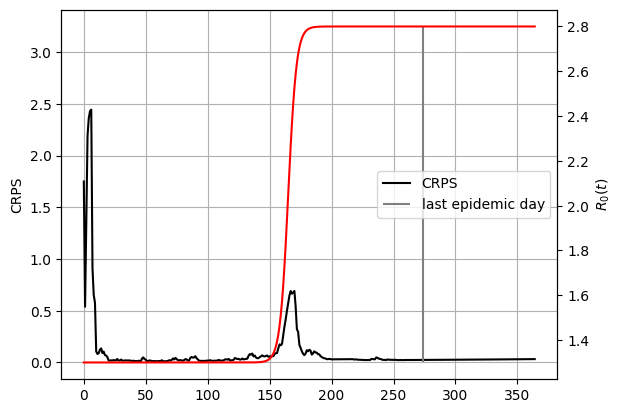

In [97]:
pp = 6115
last_epi_day = compute_days_df.loc[compute_days_df.param == pp, 'last_epi_day'].values
fig, ax = plt.subplots()
ax.plot(np.mean(crps_all_runs, axis=0), color='k', label='CRPS')
ax.vlines(last_epi_day, 0, np.max(crps_all_runs), color='gray', label='last epidemic day')
ax.grid()
ax.set_ylabel('CRPS')
ax.legend(loc='center right')

ax2 = ax.twinx()
ax2.plot(eakf.data.rt, color='red', label=r'true $R_0(t)$')
ax2.set_ylabel(r'$R_0(t)$')

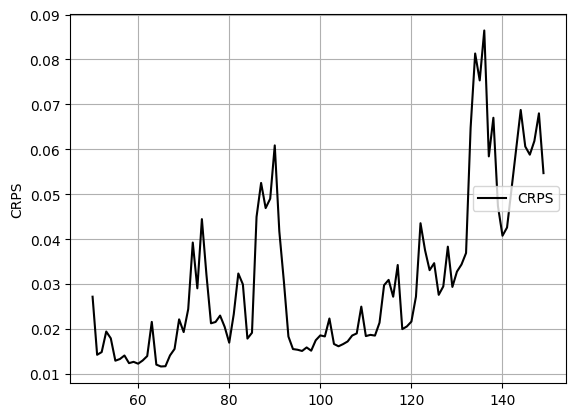

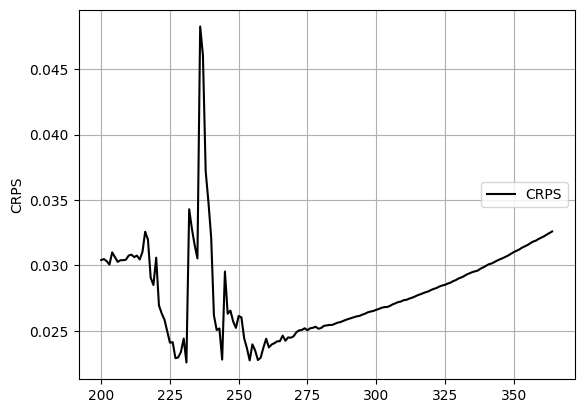

In [110]:
fig, ax = plt.subplots()
ax.plot(np.arange(50,150), np.mean(crps_all_runs, axis=0)[50:150], color='k', label='CRPS')
ax.grid()
ax.set_ylabel('CRPS')
ax.legend(loc='center right')

fig, ax = plt.subplots()
ax.plot(np.arange(200,365), np.mean(crps_all_runs, axis=0)[200:365], color='k', label='CRPS')
ax.grid()
ax.set_ylabel('CRPS')
ax.legend(loc='center right')

### 4. RMSE

In [25]:
rmse = np.mean(np.square((post_rts - truth[:,np.newaxis])), axis=1)
rmse_scores = np.argsort(rmse)
np.argsort(rmse)[:5]


array([66, 65, 64, 67, 60])

### Composite score of all metrics?
Just take the average of the rankings for each metric? Effecitively giving each metric the same weighting.


In [26]:
rank_df = pd.DataFrame(
    np.array([
        np.arange(len(rank_hist_scores)),
        rank_hist_scores,
        reliability_scores,
        crps_scores,
        rmse_scores]).T, 
    columns = ["day", "rank_hist", "reliability", "crps", "rmse"]
)
rank_df["type"] = "adaptive"
rank_df['average'] = np.argsort(rank_df[["rank_hist", "reliability", "crps", "rmse"]].mean(axis=1))

The following plot is a parallel coordinates plot, showing the "ranking" of using each metric. For each metric, lower is better. A few observations
 - For the rank histogram, earlier days are worse and later days are better (with a few exceptions)
 - Horizontal lines indicate consistent rankings between metrics. 

In [27]:
rank_df[["day", "rank_hist", "reliability", "crps", "rmse", "average"]].corr()

day  rank_hist  reliability      crps      rmse   average
day          1.000000  -0.720650    -0.307452  0.058117  0.274266 -0.301949
rank_hist   -0.720650   1.000000     0.275324  0.082072 -0.138749  0.106984
reliability -0.307452   0.275324     1.000000  0.184177  0.044047  0.028687
crps         0.058117   0.082072     0.184177  1.000000  0.506424 -0.309145
rmse         0.274266  -0.138749     0.044047  0.506424  1.000000 -0.289060
average     -0.301949   0.106984     0.028687 -0.309145 -0.289060  1.000000

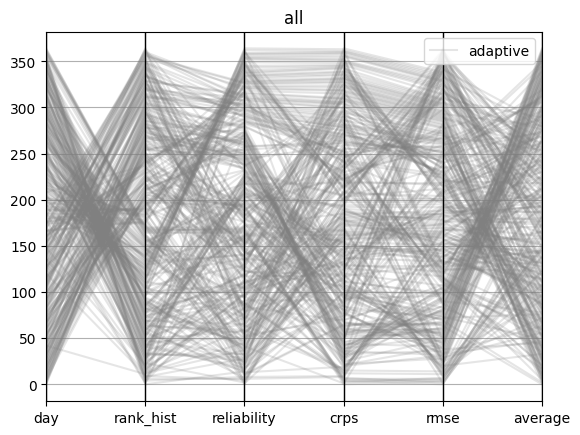

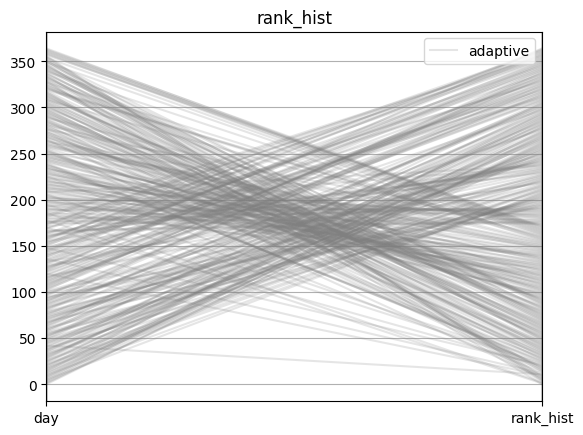

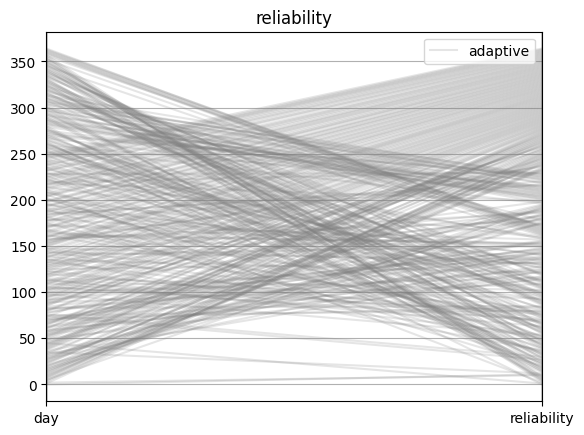

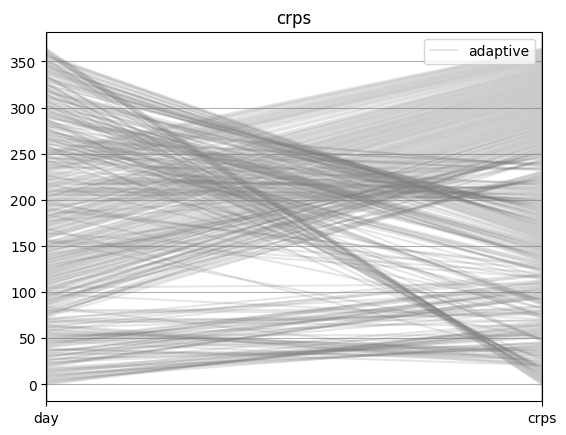

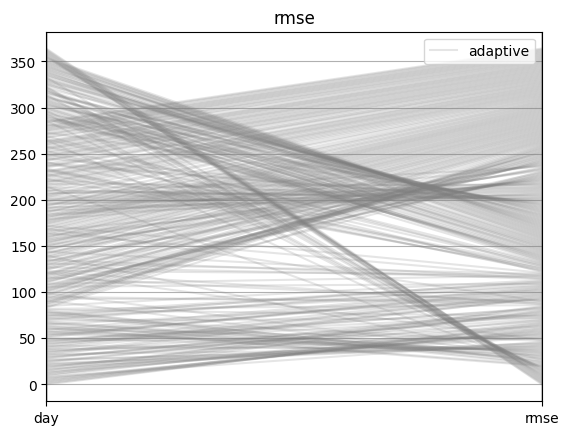

Text(0, 0.5, '$R_0(t)$')

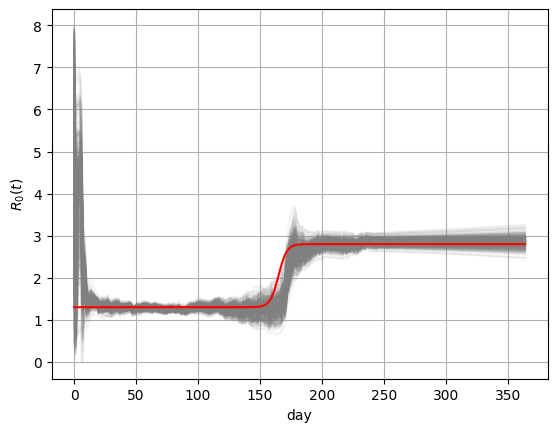

In [28]:
from pandas.plotting import parallel_coordinates

parallel_coordinates(rank_df, 'type', color='gray', alpha=0.2)
plt.title('all')
plt.show()

parallel_coordinates(rank_df[["day", "rank_hist", "type"]], 'type', color='gray', alpha=0.2)
plt.title('rank_hist')
plt.show()

parallel_coordinates(rank_df[["day", "reliability", "type"]], 'type', color='gray', alpha=0.2)
plt.title('reliability')
plt.show()

parallel_coordinates(rank_df[["day", "crps", "type"]], 'type', color='gray', alpha=0.2)
plt.title('crps')
plt.show()

parallel_coordinates(rank_df[["day", "rmse", "type"]], 'type', color='gray', alpha=0.2)
plt.title('rmse')
plt.show()

fig, ax = plt.subplots()

for run in range(1):
    file = run_dir + f"{pp}_adaptive_inflation_run_{run}.pkl"
    eakf = open_pickle(file)
    post_rts = np.array([θ.beta * θ.t_I for θ in eakf.θ_list])
    ax.plot(post_rts, color='gray', alpha=0.1)

ax.plot(truth, color='r')
ax.grid()
ax.set_xlabel('day')
ax.set_ylabel(r'$R_0(t)$')

## Run for 100 parameter scenarios

In [240]:
param_df = pd.read_csv("/ifs/scratch/jls106_gp/nhw2114/repos/rt-estimation/src/epyfilter/c2b2/20240226_metric_date_experiment_param_list.csv")

In [241]:
# import random

# # sample 100 rows without replacement
# random.seed(1994)
# idx = random.sample(range(1, len(param_df)), 100)

# param_df.iloc[idx].to_csv(
#     "/ifs/scratch/jls106_gp/nhw2114/repos/rt-estimation/src/epyfilter/c2b2/20240226_metric_date_experiment_param_list.csv", index=False)


I talked with Sen, and we agree that the rank histogram and reliability plots DO NOT make sense to use here.

- Usually these are computed for our observation state (which is assumed to have noise) and not for our parameters since these are assumed to be fixed.
- The way I implemented the rank histograms and reliability plots in order to generate one for each day was to run multiple realizations of the EAKF + (no, fixed, adaptive, smooth) inflation. This does not make sense since because we actually want there to be little variation in the EAKF from run to run. If there are large differences, 

In [242]:
# files = glob.glob("/ifs/scratch/jls106_gp/nhw2114/data/20240226_metric_date_experiment/rankings/*_rank_df.csv")
# df_list = []

# for file in files:
#     df = pd.read_csv(file)
#     pp = os.path.basename(file).split("_")[0]
#     df['param'] = int(pp)
#     df_list.append(df)
    
# ranking_df = pd.concat(df_list)

# ranking_df.to_csv("/ifs/scratch/jls106_gp/nhw2114/data/20240226_metric_date_experiment/rankings/all_ranking.csv", index=False)

In [243]:
ranking_df = pd.read_csv("/ifs/scratch/jls106_gp/nhw2114/data/20240226_metric_date_experiment/rankings/all_ranking.csv")
compute_days_df = pd.read_csv("/ifs/scratch/jls106_gp/nhw2114/repos/rt-estimation/src/epyfilter/c2b2/compute_days.csv")

In [248]:
merge_df = ranking_df.merge(compute_days_df[["param","last_epi_day"]], on="param")

- CRPS and RMSE are pretty correlated as expected
- When looking at correlations between `day` and `crps` or `rmse`, positive correlation means that latter days do worse

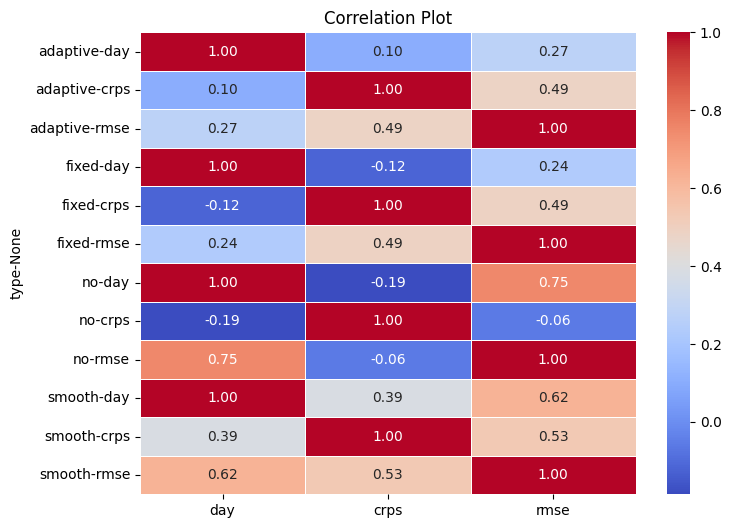

In [244]:
corr_matrix = ranking_df.loc[:,['type', 'day','crps','rmse']].groupby('type').corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Plot')
plt.show()

In [265]:
ranking_df.loc[ranking_df.crps >= 350].groupby("type").mean().loc[:,["day"]]

day
type                
adaptive  228.715333
fixed     131.655333
no         79.369333
smooth    255.558333

In [266]:
ranking_df.loc[ranking_df.rmse >= 350].groupby("type").mean().loc[:,["day"]]

day
type                
adaptive  286.897333
fixed     184.483333
no        286.852667
smooth    317.976667

Text(0, 0.5, 'RMSE ranking (lower is better)')

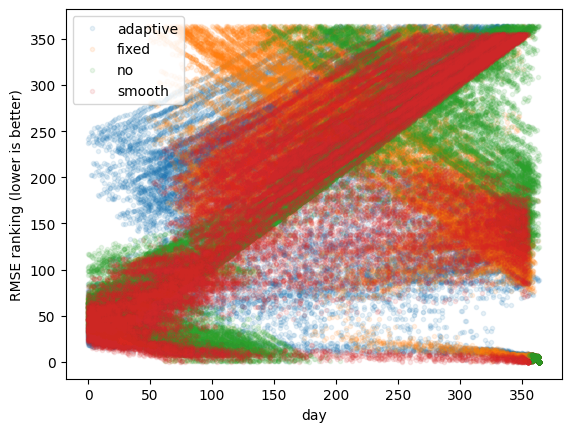

In [186]:
fig, ax = plt.subplots()

# ax.plot(merge_df.day, merge_df.rmse, '.', label= merge_df.type)

groups = merge_df.groupby('type')
for name, group in groups:
    ax.plot(group.day, group.rmse, marker='.', linestyle='', alpha=0.1, label=name)
ax.legend()
ax.set_xlabel('day')
ax.set_ylabel('RMSE ranking (lower is better)')


THIS PLOT IS GROSS LOL

Text(0.5, 1.0, 'RMSE Ranking by method (avg over diff params)')

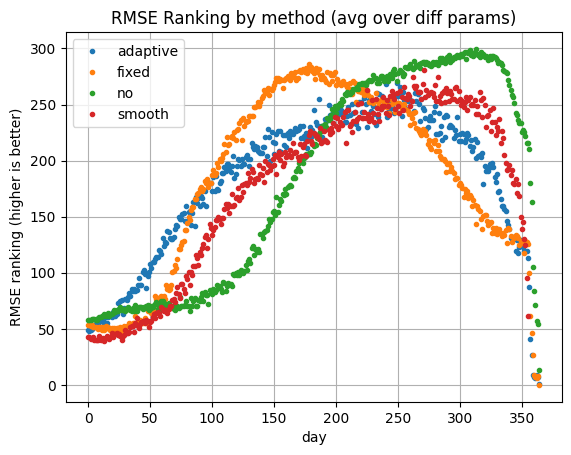

In [232]:
fig, ax = plt.subplots()

groups = merge_df.groupby(['day','type']).mean()
groups = groups.reset_index().groupby('type')

for group_name, group_data in groups:
    ax.plot(group_data.day, group_data.rmse, marker='.', linestyle='', label=group_name)
ax.legend()
ax.set_xlabel('day')
ax.set_ylabel('RMSE ranking (higher is better)')
ax.grid()

ax.set_title('RMSE Ranking by method (avg over diff params)')

Text(0.5, 1.0, 'CRPS Ranking by method (avg over diff params)')

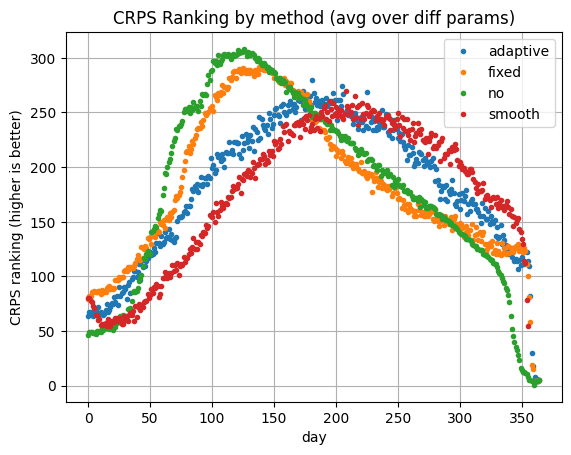

In [233]:
fig, ax = plt.subplots()

groups = merge_df.groupby(['day','type']).mean()
groups = groups.reset_index().groupby('type')

for group_name, group_data in groups:
    ax.plot(group_data.day, group_data.crps, marker='.', linestyle='', label=group_name)
ax.legend()
ax.set_xlabel('day')
ax.set_ylabel('CRPS ranking (higher is better)')
ax.grid()

ax.set_title('CRPS Ranking by method (avg over diff params)')

### Compare last_epi_day to best calibration dates

On average, the top 5 ranked are ~ 100 days away from the last epidemic day. That's pretty bad.

smooth CRPS, Last Epi Day 42.33833333333333
adaptive CRPS, Last Epi Day 19.932
no CRPS, Last Epi Day -138.856
fixed CRPS, Last Epi Day -82.508


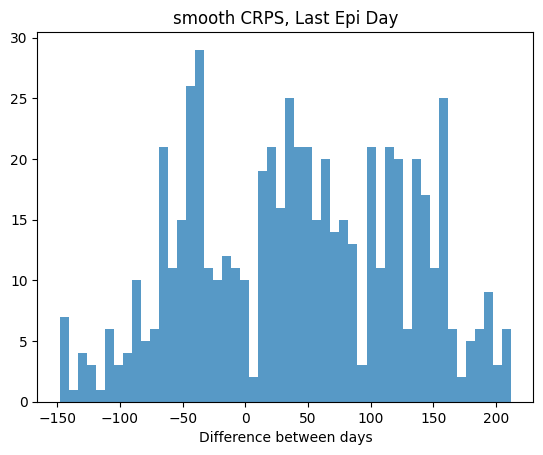

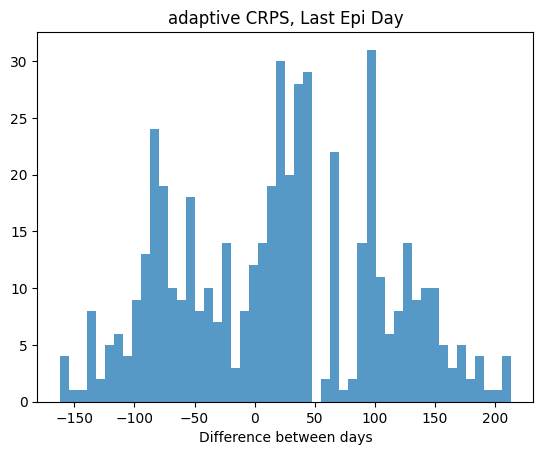

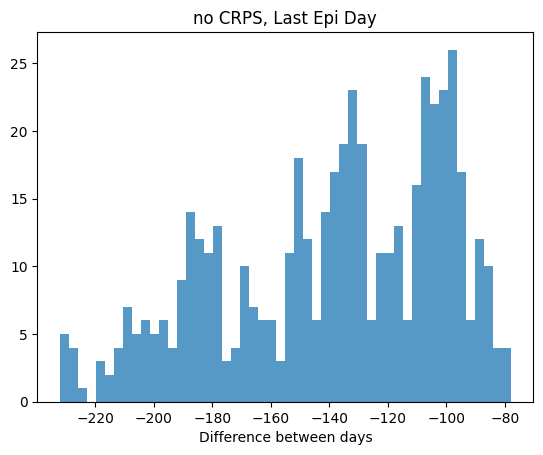

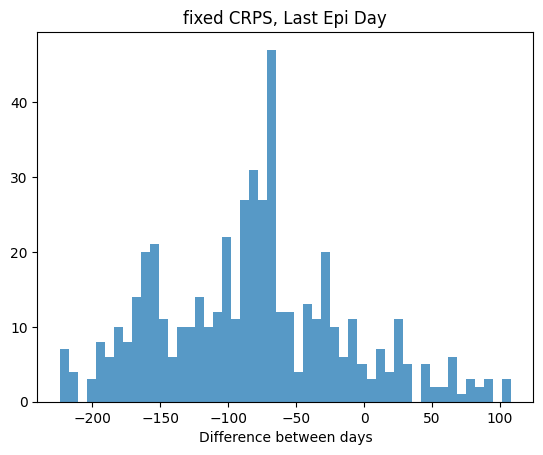

In [346]:
def mean_and_hist(data, method):
    print(method, np.mean(data))
    fig, ax = plt.subplots()
    ax.hist(data, bins = 50, alpha=0.75)
    ax.set_xlabel('Difference between days')
    ax.set_title(method)
    
# CRPS
methods = ['smooth', 'adaptive', 'no', 'fixed']

for method in methods:
    if method == 'smooth':
        top_rankings = 350
    else:
        top_rankings = 360
    ff = (merge_df.type == method) & (merge_df.crps >= top_rankings)
    data = merge_df.loc[ff].day - merge_df.loc[ff].last_epi_day
    mean_and_hist(data, method + ' CRPS, Last Epi Day')

smooth RMSE, Last Epi Day 104.75666666666666
adaptive RMSE, Last Epi Day 80.162
no RMSE, Last Epi Day 75.374
fixed RMSE, Last Epi Day -29.8


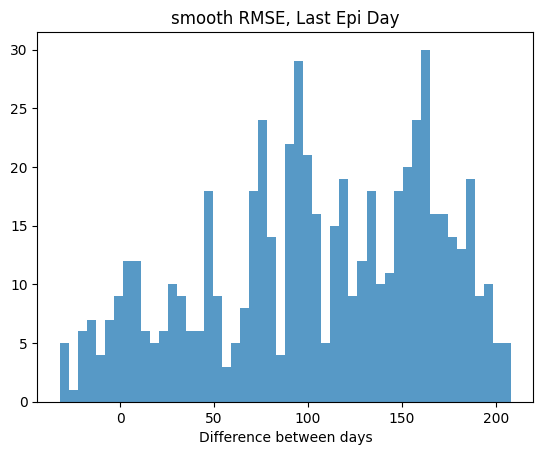

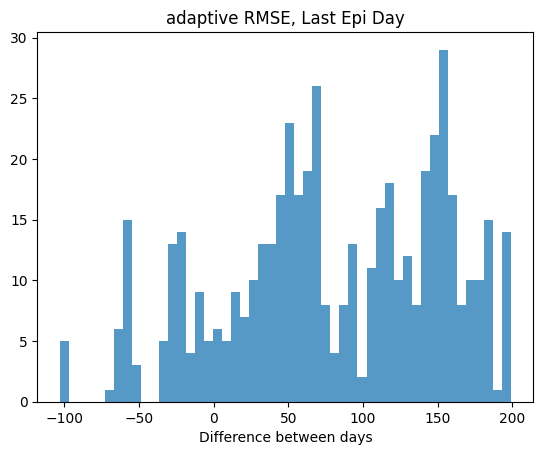

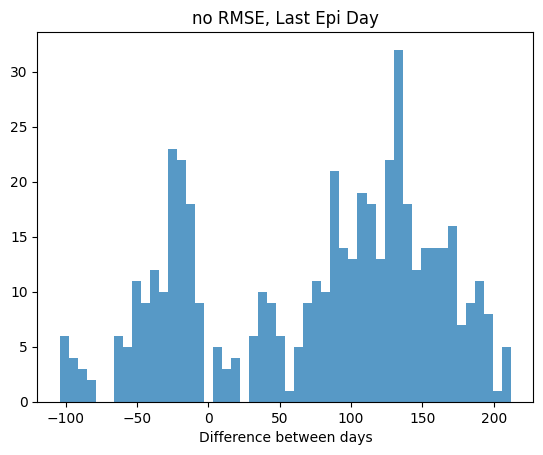

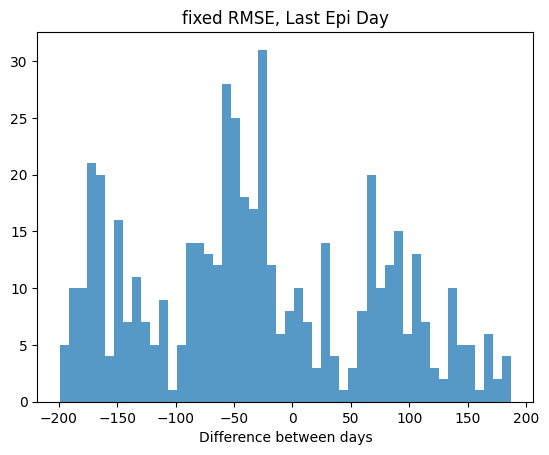

In [348]:
# RMSE

for method in methods:
    if method == 'smooth':
        top_rankings = 350
    else:
        top_rankings = 360
    ff = (merge_df.type == method) & (merge_df.rmse >= top_rankings)
    data = merge_df.loc[ff].day - merge_df.loc[ff].last_epi_day
    mean_and_hist(data, method + ' RMSE, Last Epi Day')

### That failed look at midpoint


In [349]:
param_values = pd.read_csv(
    "/ifs/scratch/jls106_gp/nhw2114/repos/rt-estimation/src/epyfilter/c2b2/param_list.csv")
param_values['param'] = param_values.index

In [350]:
merge_df = merge_df.merge(param_values[['param','midpoint']])

smooth RMSE, Sigmoid midpoint 192.07666666666665
adaptive RMSE, Sigmoid midpoint 167.482
no RMSE, Sigmoid midpoint 162.694
fixed RMSE, Sigmoid midpoint 57.52


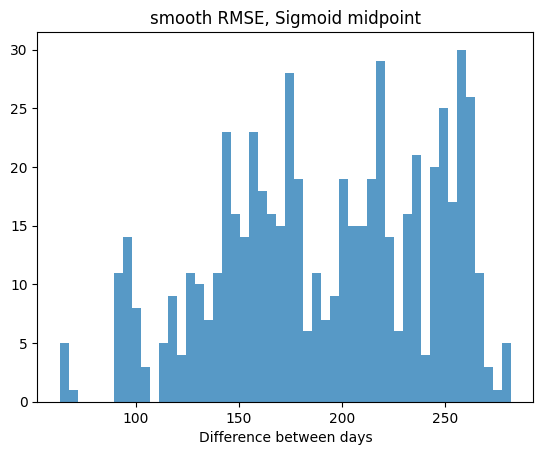

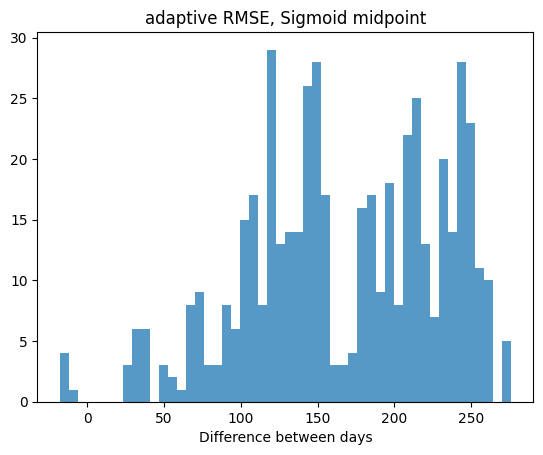

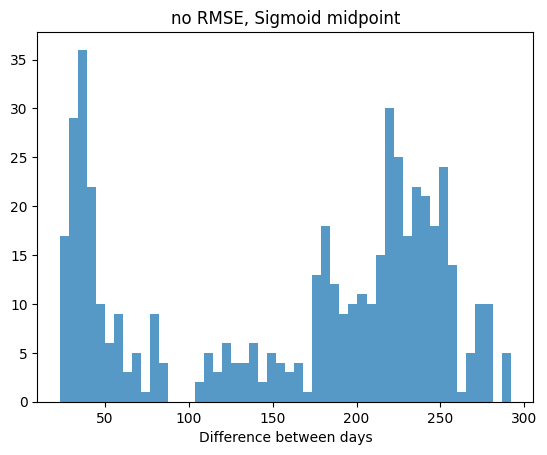

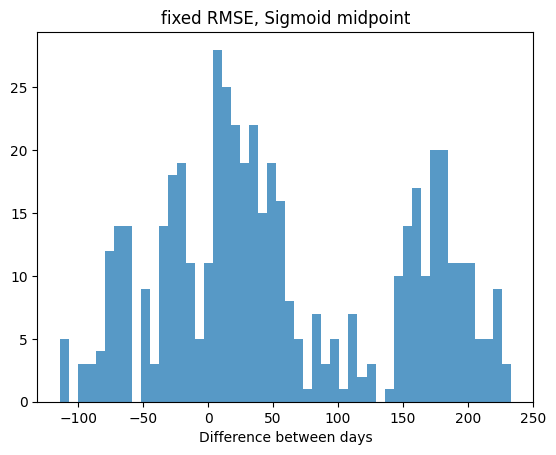

In [353]:
for method in methods:
    if method == 'smooth':
        top_rankings = 350
    else:
        top_rankings = 360
    ff = (merge_df.type == method) & (merge_df.rmse >= top_rankings)
    data = merge_df.loc[ff].day - merge_df.loc[ff].midpoint
    mean_and_hist(data, method + ' RMSE, Sigmoid midpoint')

smooth CRPS, Sigmoid Midpoint 129.65833333333333
adaptive CRPS, Sigmoid Midpoint 107.252
no CRPS, Sigmoid Midpoint -51.536
fixed CRPS, Sigmoid Midpoint 4.812


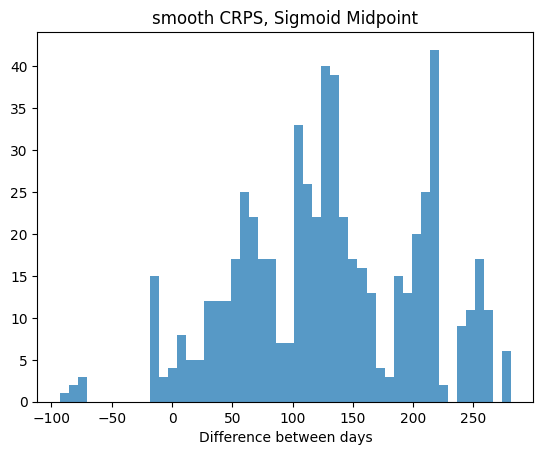

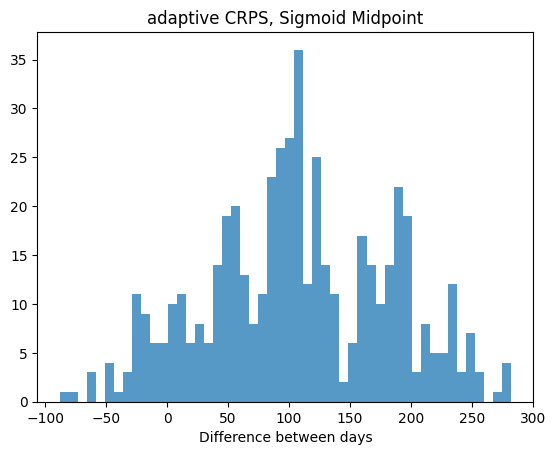

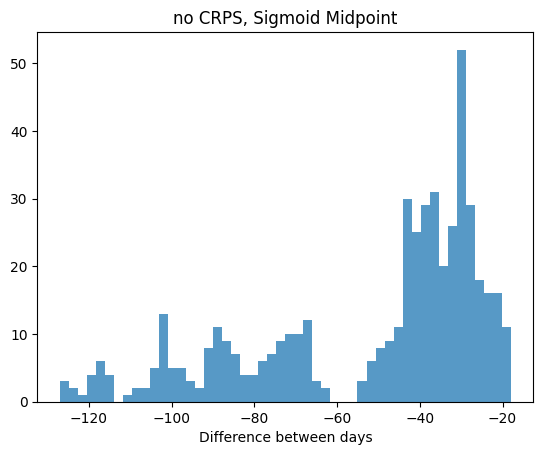

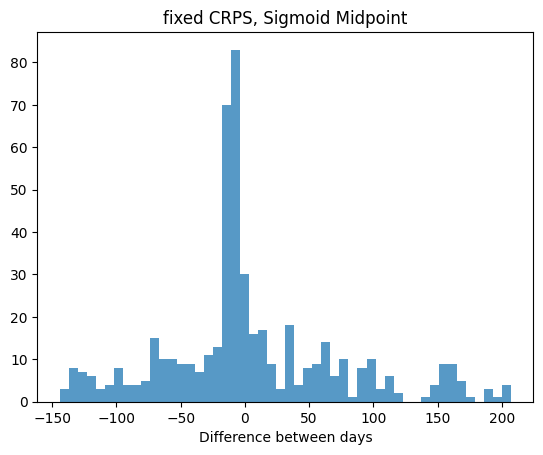

In [354]:
for method in methods:
    if method == 'smooth':
        top_rankings = 350
    else:
        top_rankings = 360
    ff = (merge_df.type == method) & (merge_df.crps >= top_rankings)
    data = merge_df.loc[ff].day - merge_df.loc[ff].midpoint
    mean_and_hist(data, method + ' CRPS, Sigmoid Midpoint')